# Toxic Comment Classification

## 1) Importing Libraries

In [1]:
# need latest version of matplotlib >=(3.4.1)
!pip install --upgrade matplotlib

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.7/dist-packages (3.4.2)


In [3]:
#installing required libraries
!pip install venn
!pip install contractions
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 3.2MB/s 


In [6]:
#mandatory libraries
import os
import re
import string
import numpy as np
import pandas as pd

#plotting libraries
import venn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


#NLTK libraries  & for data cleaning
import contractions
import nltk
from nltk.tree import Tree
from nltk.corpus import stopwords
from nltk import ne_chunk, pos_tag, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS

#sk-learn libraries for vectorization and TSNE
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

#miscellaneous libraries
import warnings
warnings.filterwarnings("ignore")
from tqdm.notebook import tqdm
from itertools import combinations 

In [5]:
#checking matplotlib version
matplotlib.__version__

'3.4.2'

## 2) Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 3) Loading Data-set

Data-set Source : https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data

**Disclaimer: The dataset for this case-study contains text that may be considered profane, vulgar, or offensive.**

In [ ]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/90.0.4430.85 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kagglesdsdata/competitions/8076/44219/train.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1619724179&Signature=PNpGxAYPWQlENbydMQHBET6XaAm5UqGDgB6vwWHF5RptMNw97%2FW5EQqucQzpa0SVtMXmrQo5VKqYKq3JUHYKssitvFEwcD6yH5E2hNkCBnVfHqq%2FfljMB5BWhErdk33VtTuNhDxZGEy1rESPu8u3n8T%2BjufYPYE0En07RWlUqRtIbLt%2Bv6xabDRoY3UAWuw59tq1FVjM3e5t2yMcaSr7E3xo%2BhPYpyRQXD3SJ%2Fj0rUdSkK5iHUnc%2FCHAPtckNyKBxxXg%2FjDDxx1SNKa2ImM91zlj225993pcNf3ya2Wm%2FwF%2Fi18tM0vxgHx3ieEdm0M%2Fmuxlh8%2F%2BkbcRvHOiXKv9aA%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv.zip" -c -O 'train.csv.zip'

In [ ]:
#Extracting the train.csv.zip file

from zipfile import ZipFile
file_name="./train.csv.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()

In [ ]:
#copying the extracted train.csv to google drive

!cp /content/train.csv -r /content/gdrive/MyDrive/Colab\ Notebooks/Case_Study_1/train.csv

In [ ]:
#copying train.csv file from google drive to colab run space

!cp /content/gdrive/MyDrive/Colab\ Notebooks/Case_Study_1/train.csv -r /content/train.csv

In [ ]:
#reading train.csv file using pandas

data=pd.read_csv("train.csv")

## 4) EDA & Studying the Data-set

### 4.1 Shape of the Data-set

In [ ]:
# total dataset size
data.shape

(159571, 8)

In [ ]:
#row and column information of data set
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


We have 1,59,571 rows and 8 columns of data. Out of 8 columns, we have 2 object d-type (strings are refered as objects in python) and 6 int64 d-type columns. These 6 columns are target labels for the task.

### 4.2 Checking the Missing Values in Data-set

In [ ]:
#checking any null/nan present in dataset
data.isnull().values.any()

False

No missing values in any of the columns

### 4.3 Checking the Duplicate Values in Data-set

In [ ]:
#checking if any duplicate entries exists.
data.duplicated().values.any()

False

No duplicate entries found

### 4.4 Basic Statistics

In [ ]:
# basic statistics like mean, standard deviation, and percentiles
data.describe()

toxic   severe_toxic  ...         insult  identity_hate
count  159571.000000  159571.000000  ...  159571.000000  159571.000000
mean        0.095844       0.009996  ...       0.049364       0.008805
std         0.294379       0.099477  ...       0.216627       0.093420
min         0.000000       0.000000  ...       0.000000       0.000000
25%         0.000000       0.000000  ...       0.000000       0.000000
50%         0.000000       0.000000  ...       0.000000       0.000000
75%         0.000000       0.000000  ...       0.000000       0.000000
max         1.000000       1.000000  ...       1.000000       1.000000

[8 rows x 6 columns]

1) From the above output, once again it is clear that no values are missing in any of the columns. 

2) Since id and comment_text are text features, no mean, std, 25th, 50th,75th percentiles are caluculated. 

3) Since, only target labels are numeric in our dataset, describe function calculated basic statistics on targets.

### 4.5 Checking the Random Data

In [ ]:
# first 5 data entries
data.head()

id  ... identity_hate
0  0000997932d777bf  ...             0
1  000103f0d9cfb60f  ...             0
2  000113f07ec002fd  ...             0
3  0001b41b1c6bb37e  ...             0
4  0001d958c54c6e35  ...             0

[5 rows x 8 columns]

In [ ]:
# random 10-data entries
data.sample(10)

id  ... identity_hate
57890   9afb8da94df871ae  ...             0
149477  5c914dadc0258dd7  ...             0
60209   a125552cf51e5bb7  ...             0
32855   5769d91f266e813a  ...             0
39938   6a9c4cf3d2863f4d  ...             0
54830   92875154a0028db9  ...             0
12932   22432d8b93f62a1c  ...             0
58967   9de7e92489d7316a  ...             0
152700  914a0e447ba5c617  ...             0
118112  76f62f7ad38835bd  ...             0

[10 rows x 8 columns]

On observing random samples, we can conclude that our raw-input has many new line characters ("\n"), punctuation marks, capital letters, short handed texts, etc. We will clean the raw-data and make use the same for vectorization in next section.




### 4.6 Value-Counts on Target Labels Individually

In [ ]:
# checking the value counts for each targets individually

for i in data.columns.values[2:]:
    print(data[i].value_counts())
    print("="*50)

0    144277
1     15294
Name: toxic, dtype: int64
0    157976
1      1595
Name: severe_toxic, dtype: int64
0    151122
1      8449
Name: obscene, dtype: int64
0    159093
1       478
Name: threat, dtype: int64
0    151694
1      7877
Name: insult, dtype: int64
0    158166
1      1405
Name: identity_hate, dtype: int64


From the above output, we can understand that the data set is highly imbalanced.

Let us represent the above output with bar-graph.

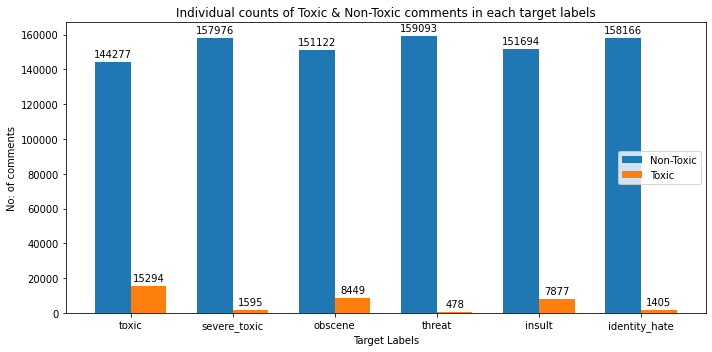

In [ ]:
# the below code is taken from official documentation of matplotlib

# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html

labels = data.columns.values[2:]
class_0=[]
class_1=[]

for i in data.columns.values[2:]:
    vc=data[i].value_counts()
    class_0.append(vc[0])
    class_1.append(vc[1])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,5))
rects1 = ax.bar(x - width/2, class_0, width, label='Non-Toxic')
rects2 = ax.bar(x + width/2, class_1, width, label='Toxic')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('No: of comments')
ax.set_xlabel("Target Labels")
ax.set_title('Individual counts of Toxic & Non-Toxic comments in each target labels')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc=7)

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

ax.bar
fig.tight_layout()

plt.show()

1) The above plot is the individual counts of class zero & class 1, ie comment is classified as toxic= class 1 and comment is classified as non-toxic= class 0.

2) From this plot we can understand that the data set is highly imbalanced.

3) This is pictorial representation of value counts of classes, for each target individually

### 4.7 Value-Counts on Target Labels Collectively

In the above plot, we considered all the target labels are independent. ie we counted no:of toxic/non-toxic comments individually. But as per the problem statement, A comment may belongs to none or more targets labels. Now, we take all this into consideration and count collectively.


In [ ]:
# we can also do this task with use data.value_counts(), 
# but the readability of the o/p is not quite hard.

# thats why i took only labels data for all the rows 
#coverted numpy array with int dtype and counted unique elements using
#numpy.unique() and to present neatly, 
#i created one more data frame with counts sorted in desc.

lbls=data.values[:,2:] #taking only target label data for all rows 
lbls=np.array(lbls,dtype=int) #converting into numpy array
col_lbls=np.unique(lbls, return_counts=True,axis=0)
col_lbls_df=pd.DataFrame(columns=data.columns.values[2:],data=col_lbls[0])
col_lbls_df['count']=col_lbls[1]
col_lbls_df=col_lbls_df.sort_values(by=['count'],ascending=False)


print("Shape of the Collective Labels (including count-column) = ",col_lbls_df.shape)
print("\n")
col_lbls_df

Shape of the Collective Labels (including count-column) =  (41, 7)




toxic  severe_toxic  obscene  threat  insult  identity_hate   count
0       0             0        0       0       0              0  143346
12      1             0        0       0       0              0    5666
22      1             0        1       0       1              0    3800
20      1             0        1       0       0              0    1758
14      1             0        0       0       1              0    1215
36      1             1        1       0       1              0     989
23      1             0        1       0       1              1     618
6       0             0        1       0       0              0     317
2       0             0        0       0       1              0     301
37      1             1        1       0       1              1     265
8       0             0        1       0       1              0     181
34      1             1        1       0       0              0     158
13      1             0        0       0       0              1     136
15      1             0        0       0       1              1     134
25      1             0        1       1       1              0     131
16      1             0        0       1       0              0     113
39      1             1        1       1       1              0      64
26      1             0        1       1       1              1      56
1       0             0        0       0       0              1      54
27      1             1        0       0       0              0      41
21      1             0        1       0       0              1      35
40      1             1        1       1       1              1      31
3       0             0        0       0       1              1      28
4       0             0        0       1       0              0      22
9       0             0        1       0       1              1      18
18      1             0        0       1       1              0      16
29      1             1        0       0       1              0      14
31      1             1        0       1       0              0      11
24      1             0        1       1       0              0      11
17      1             0        0       1       0              1       7
30      1             1        0       0       1              1       7
35      1             1        1       0       0              1       6
38      1             1        1       1       0              0       4
28      1             1        0       0       0              1       3
19      1             0        0       1       1              1       3
7       0             0        1       0       0              1       3
5       0             0        0       1       1              0       3
11      0             0        1       1       1              0       2
10      0             0        1       1       0              0       2
32      1             1        0       1       0              1       1
33      1             1        0       1       1              0       1

1) We have total of 6 target labels represented in binary format ( i.e, 1 represents, the comment belongs to a particular target label and 0 represents, the comment doesnot belongs to a particular target label). Logically, 2^6 = 64 combinations are possible. but we have data for only 41 combinations. 

2) Out of 1,59,571 comments, 1,43,346 comments belongs to none of the target labels. In other words, 89.832% of total data, has zeros in all the target labels.

3) From point 2, we can also conclude that only 16,225 comments belongs to atleast one of the 6 target labels.

4) Out of 16,225 comments, that are classified as "Positive", 5,666 comments belongs to only label-"toxic" alone, which is 34.92% of positive labels.

Since it is hard to plot all the available combinations of labels and their counts, let us count a comment that is toxic or non-toxic by considering a comment as toxic if it belongs to atleast any one of the target labels or otherwise non-toxic.

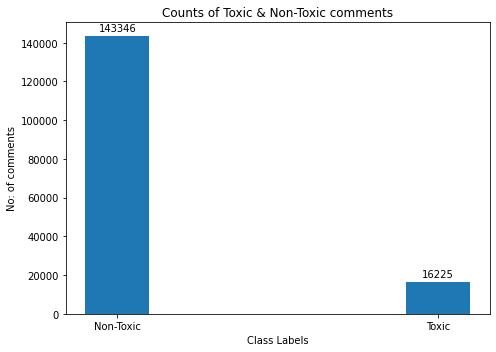

In [ ]:
#plotting toxic & non-toxic comment counts, considering from above statement
Categories=["Non-Toxic","Toxic"]
values=[0,0]

for row in col_lbls_df.values:
    if (sum(row[:-1])==0):
        values[0]=values[0]+row[-1]
    else:
        values[1]=values[1]+row[-1]

fig, ax = plt.subplots(figsize=(7,5))
rects1 = ax.bar(Categories, values, 0.2)
ax.set_ylabel('No: of comments')
ax.set_xlabel("Class Labels")
ax.set_title('Counts of Toxic & Non-Toxic comments')
ax.bar_label(rects1, padding=3)
fig.tight_layout()
plt.show()

1) Considering all the targets labels, there are 1,43,346 comments belongs to none of the target labels ie Non-Toxic. It is 89.832% of total data.

2) There are 16,225 comments belongs to atleast one of the 6 target labels, i.e toxic comments.

### 4.8 Counts of Multiple Target Labels

Now, lets plot the no: of comments  that are toxic and belongs to different no : of target labels. In other words lets count the no :of comments that belongs to multiple target labels.

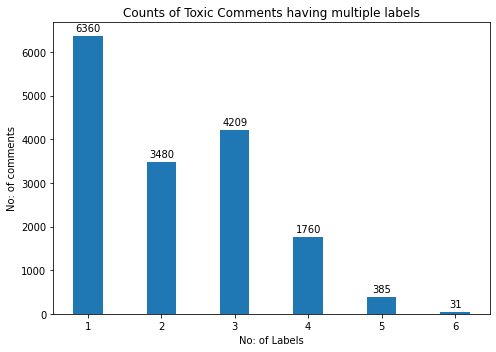

In [ ]:
no_of_possible_labels=np.arange(1,7)
values=np.zeros(6,dtype=int)

for row in col_lbls_df.values:
    if (sum(row[:-1])==1):
        values[0]=values[0]+row[-1]

    elif (sum(row[:-1])==2):
        values[1]=values[1]+row[-1]

    elif (sum(row[:-1])==3):
        values[2]=values[2]+row[-1]
    
    elif (sum(row[:-1])==4):
        values[3]=values[3]+row[-1]
    
    elif (sum(row[:-1])==5):
        values[4]=values[4]+row[-1]

    elif (sum(row[:-1])==6):
        values[5]=values[5]+row[-1]

fig, ax = plt.subplots(figsize=(7,5))
rects1 = ax.bar(no_of_possible_labels, values, 0.4)
ax.set_ylabel('No: of comments')
ax.set_xlabel("No: of Labels")
ax.set_title('Counts of Toxic Comments having multiple labels')
ax.bar_label(rects1, padding=3)
fig.tight_layout()
plt.show()

1) Out of 16,225 comments that are classified as "Positive", 6,360 comments are having only one target label. In other words 39.198 % of total comments classified as "toxic" under atlease one category.

2) Earlier we studied that 5,666 comments belongs to only label-"toxic".

3) From 1 & 2 we can conclude that only 694 (6360 - 5666 = 694) comments belongs to remaining 5 target labels individually.

4) Only 31 comments are classified under all the target labels, which is 0.1910 % of positive data points.

### 4.9 Venn Diagram on Target Labels

Lets plot the Venn Diagram for counts on multi-labels, by considering set of  2, 3, 4, 5, 6 labels

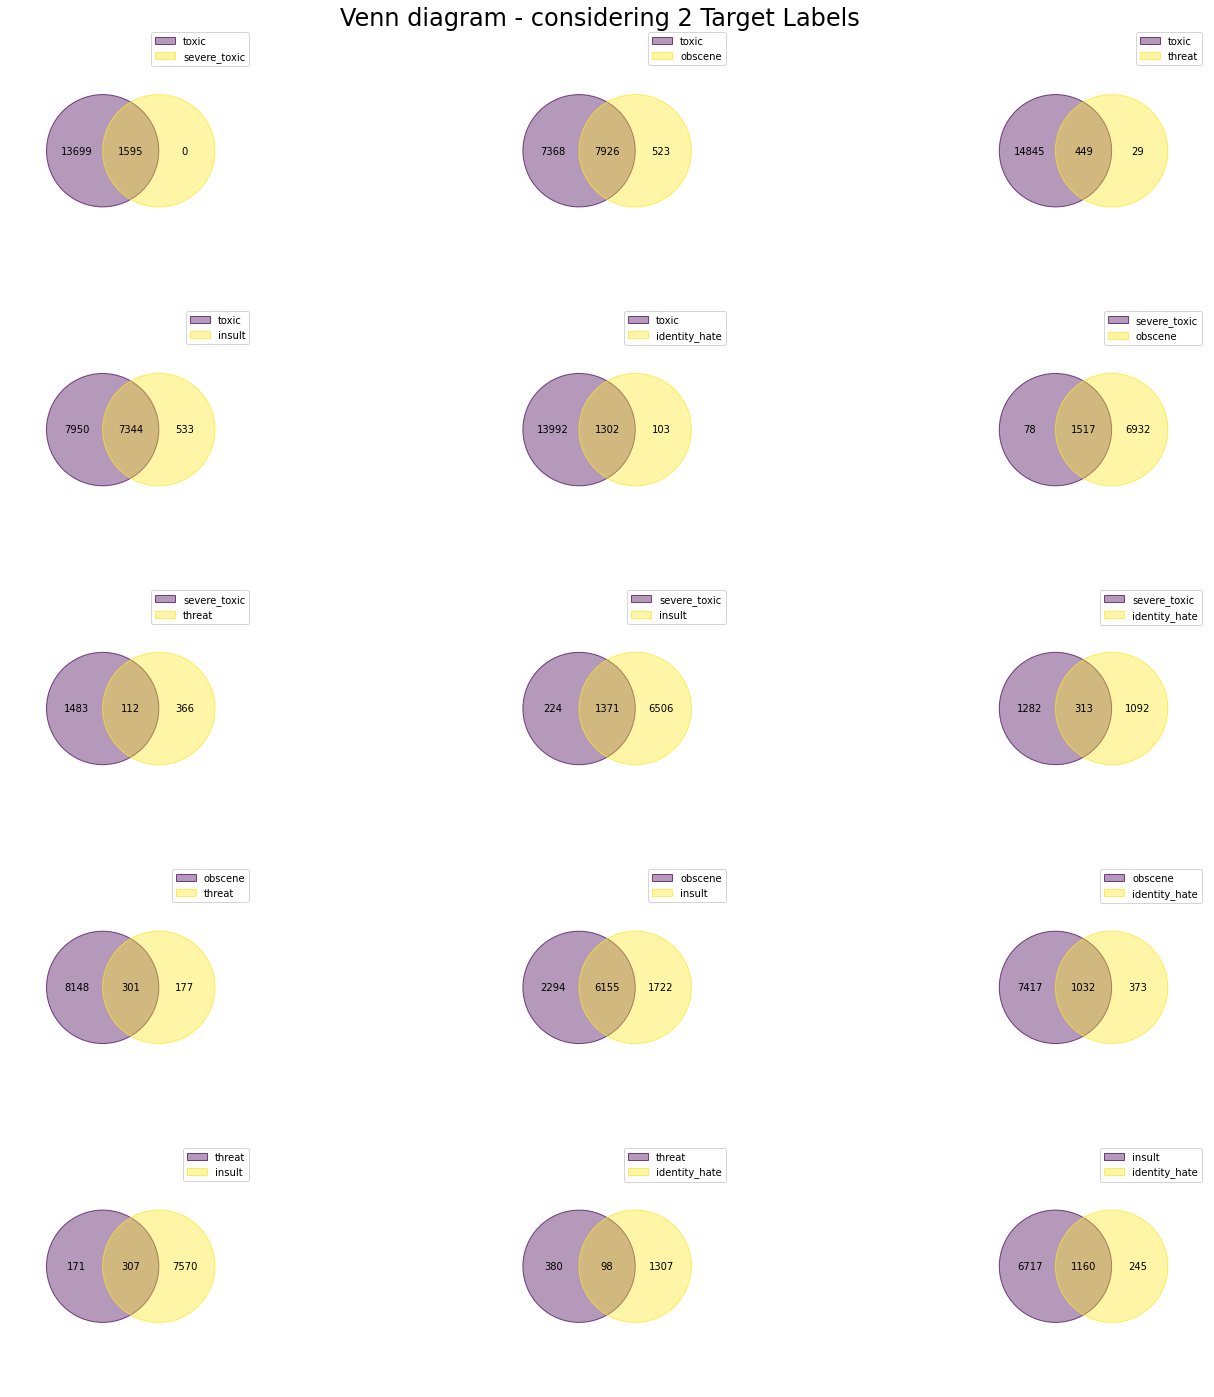

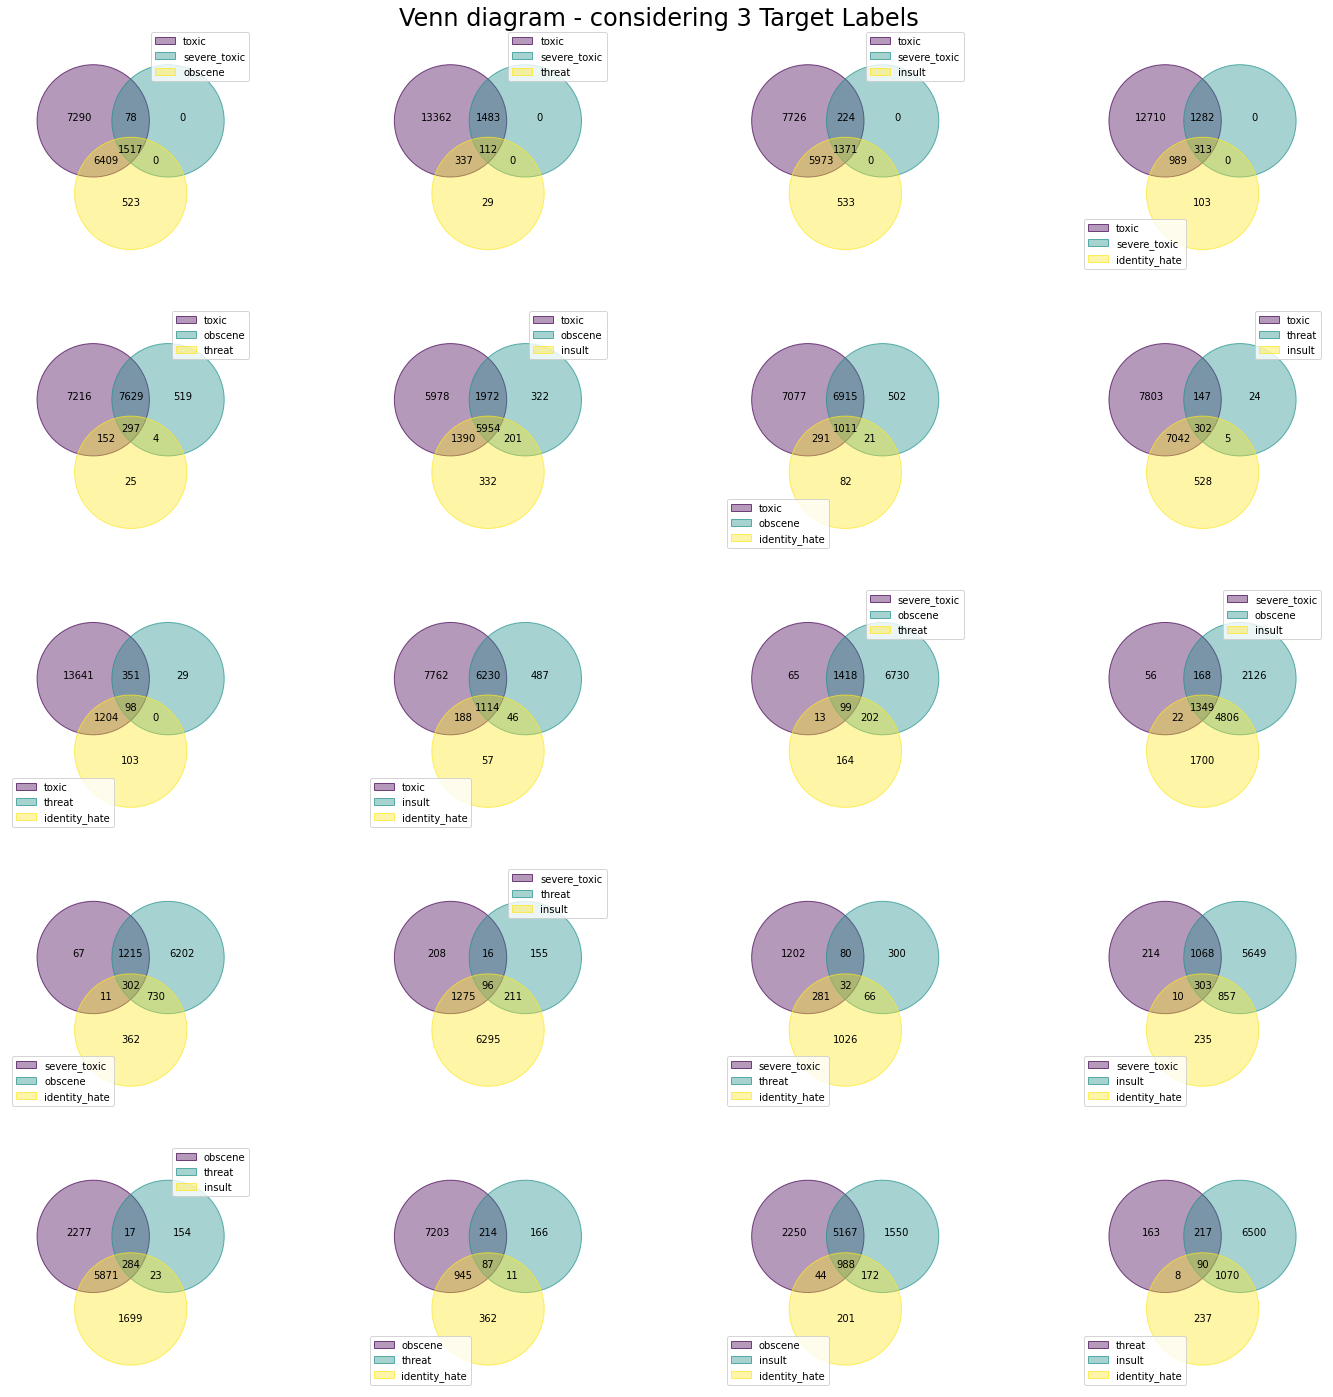

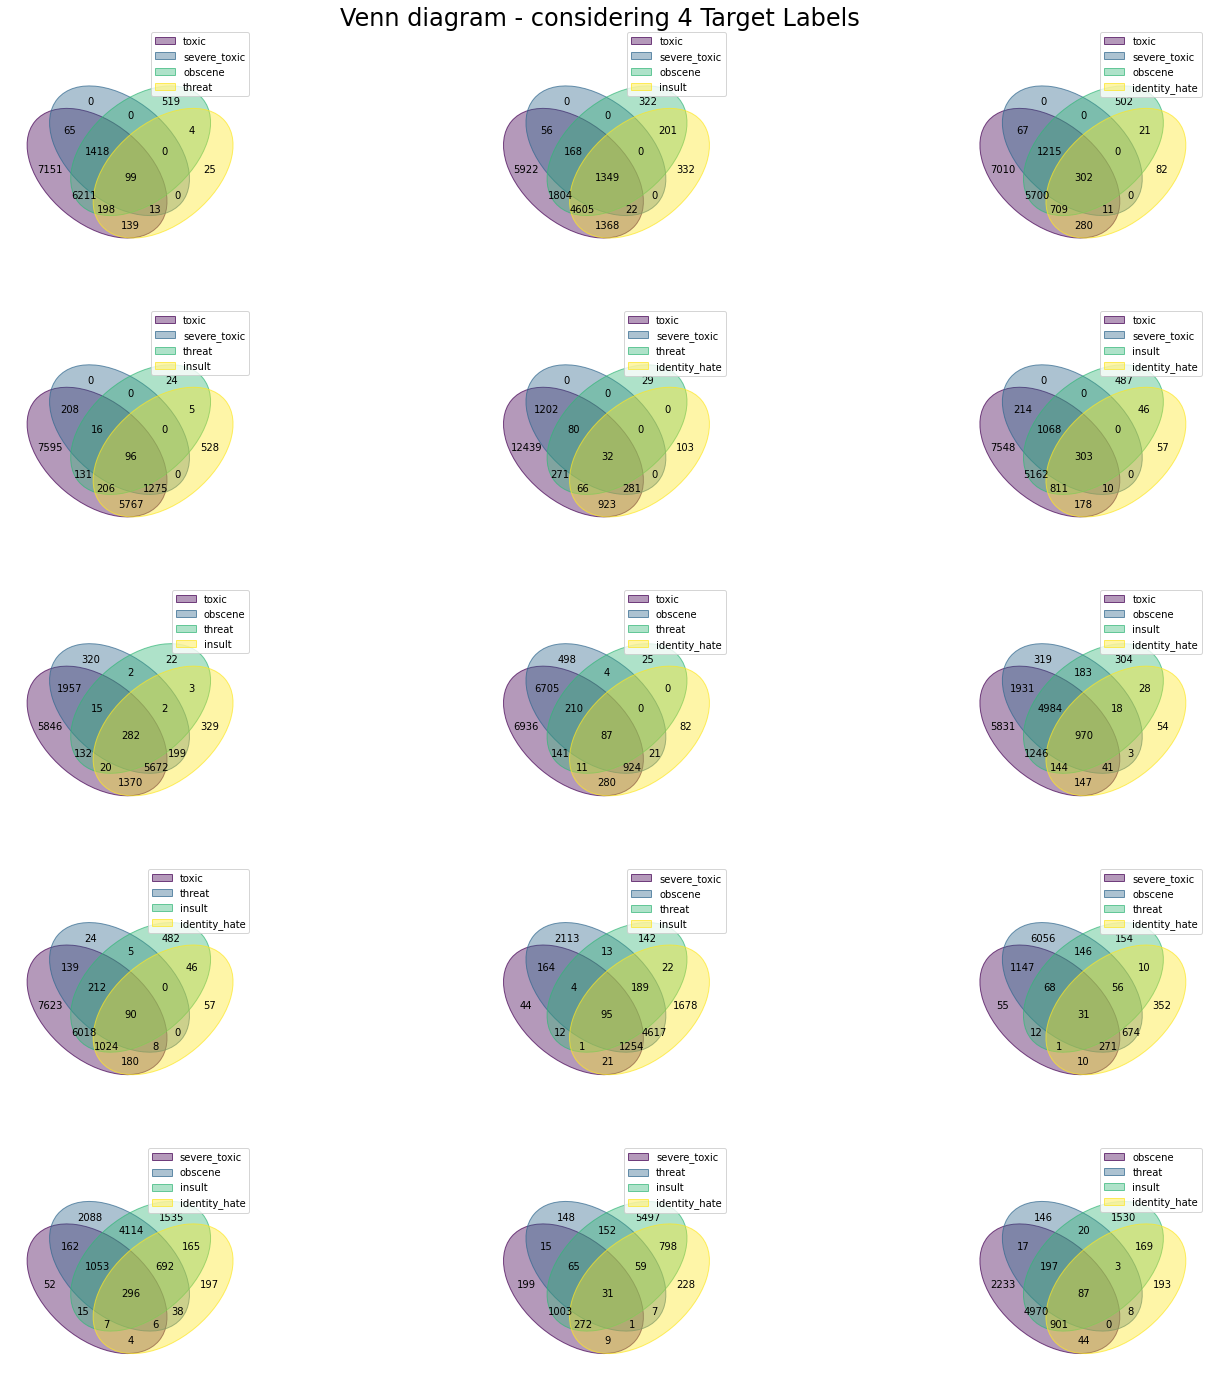

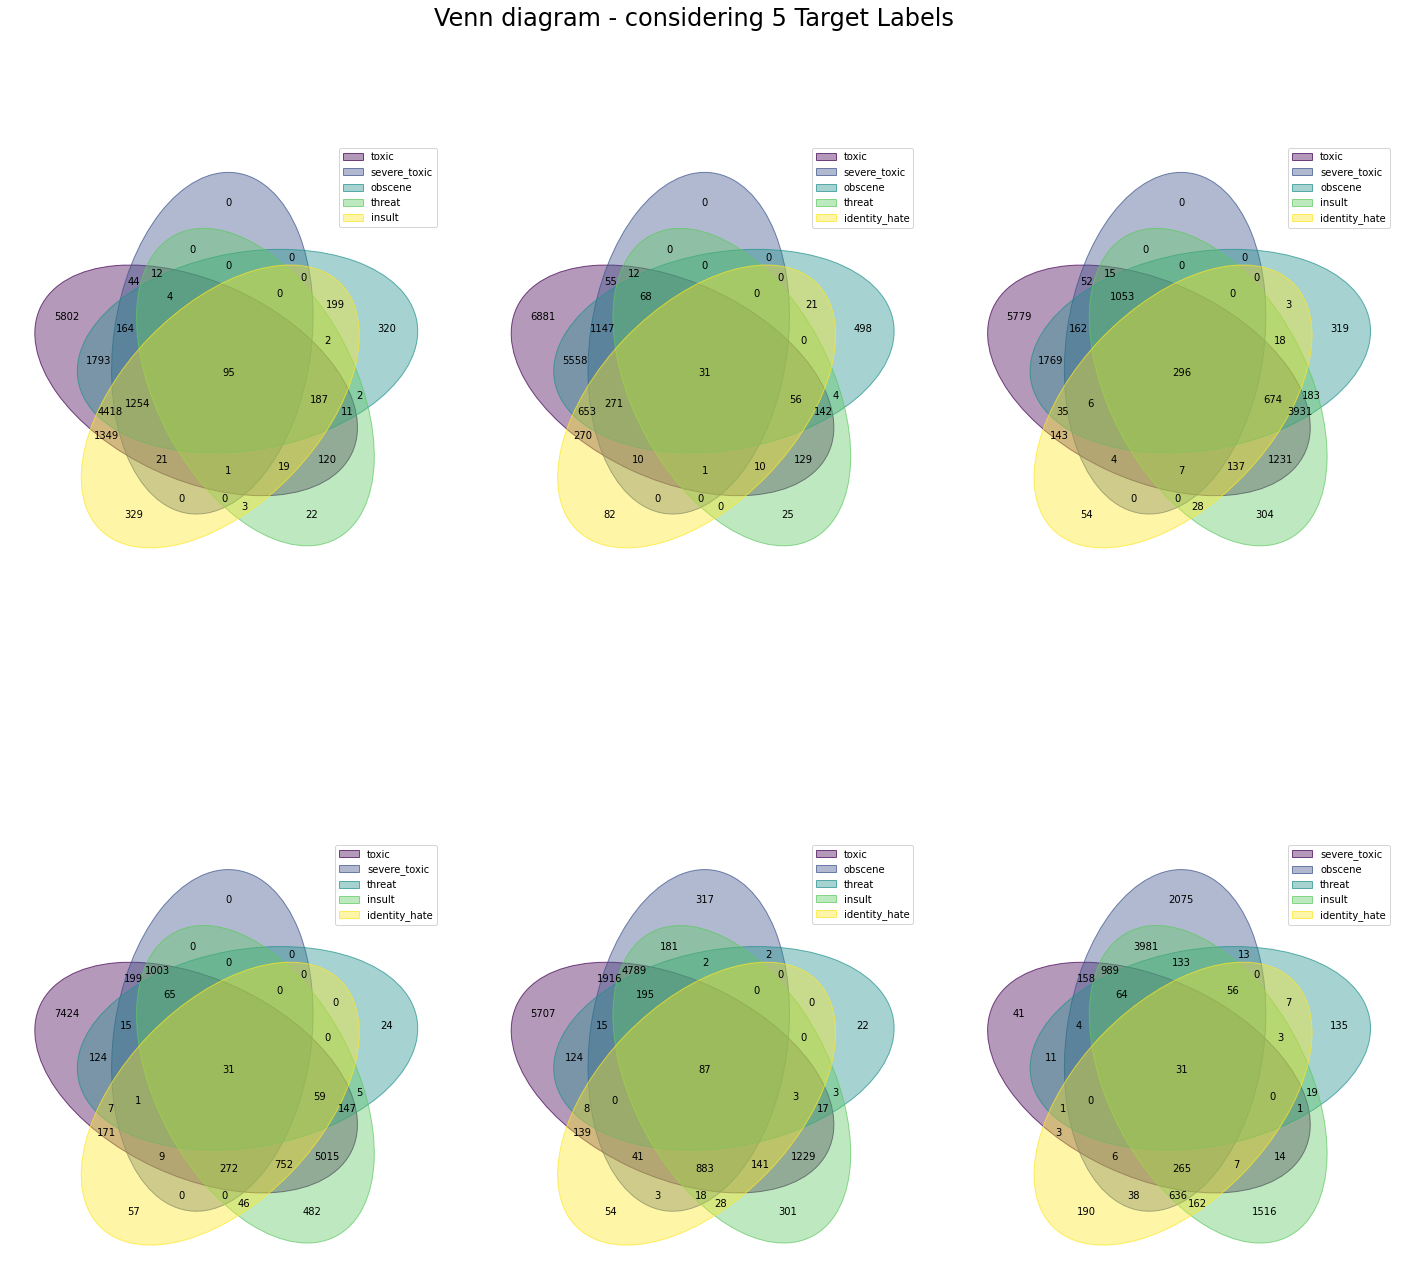

In [ ]:
no_of_labels= np.arange(2,6)
rows_col=[(5,3),(5,4),(5,3),(2,3)]


for i,rc in zip(no_of_labels,rows_col):
    comb = combinations(data.columns.values[2:], i)
    fig, top_axs = plt.subplots(ncols=rc[1], nrows=rc[0],figsize=(20, 20))
    fig.suptitle("Venn diagram - considering "+str(i)+" Target Labels",fontsize=24)
    fig.subplots_adjust(top=0.88)
    fig.tight_layout()
    top_axs=top_axs.flatten()
    for j,ax in zip(list(comb),top_axs):
        data_set=dict()
        for k in j:
            data_set[k]=set(data[(data[k]==1)].index)
        venn_dgrm=venn.venn(data_set,legend_loc="best",alpha=0.4,fontsize=10,ax=ax)

1) All Severe_Toxic class comments are Toxic. 

2) In most of the combinations Toxic class,Insult,Obscene are dominating

3) In higher combinations, some of the intersections are zero.

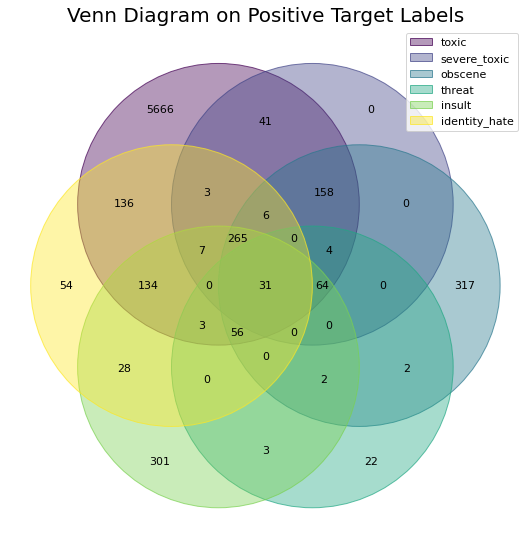

In [ ]:
#for 6 sets, by default venn.venn() draws venn diagram with triangles
#psudeovenn draws cicrle by considering only few intersections.

fig, ax = plt.subplots(figsize=(8,8))
dataset_dict = {
    col: set(data[(data[col]==1)].index)
    for col in data.columns[2:]
}
ax.set_title("Venn Diagram on Positive Target Labels",fontsize=20)
fig.tight_layout()
venn_dgrm=venn.pseudovenn(dataset_dict,hint_hidden=False,ax=ax,legend_loc="best",alpha=0.4,fontsize=11)

1) All severe_toxic comments are toxic comments.

2) We dont have data for many of the intersections. ie we see many zeros in the venn diagrams considering different set of target labels.

### 4.10 Correlation between Target Labels

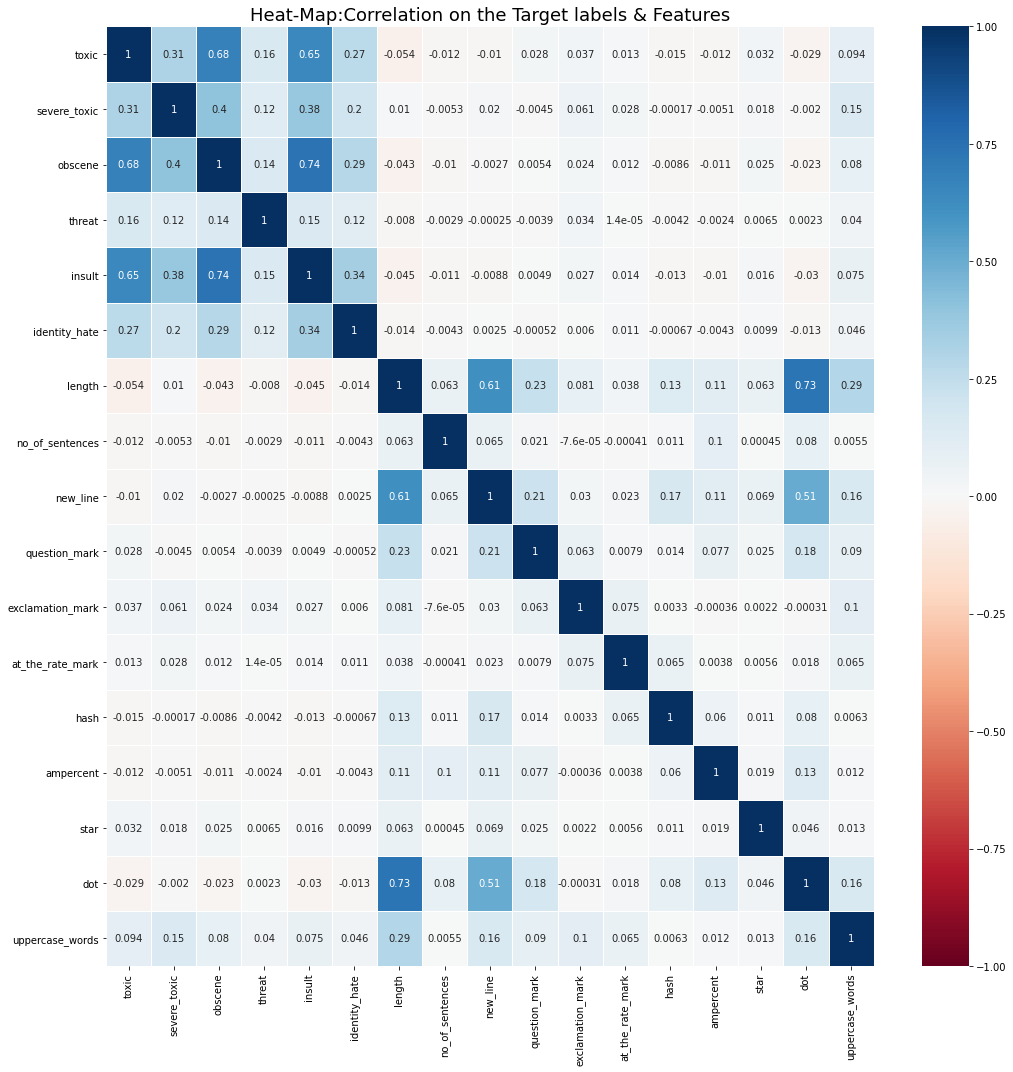

In [ ]:
corr_df=data.drop(columns=["id","comment_text"])
corr_df['length']=data['comment_text'].str.len()
corr_df['no_of_sentences']=data['comment_text'].str.split("/n").apply(len)
corr_df['new_line'] = data['comment_text'].str.count('\n')
corr_df['question_mark'] = data['comment_text'].str.count('\?')
corr_df['exclamation_mark'] = data['comment_text'].str.count('!')
corr_df['at_the_rate_mark'] = data['comment_text'].str.count('@')
corr_df['hash'] = data['comment_text'].str.count('#')
corr_df['ampercent'] = data['comment_text'].str.count('&')
corr_df['star']= data['comment_text'].str.count('\*')
corr_df['dot'] = data['comment_text'].str.count('\.')
corr_df['uppercase_words'] = data['comment_text'].str.split().apply(lambda x: sum(map(str.isupper, x)))

correlation=corr_df.corr()

plt.figure(figsize=(15,15))
sns.heatmap(correlation,vmin=-1,cmap='RdBu',annot=True,linewidths=.5)
plt.title("Heat-Map:Correlation on the Target labels & Features",fontsize=18)
plt.tight_layout()

1) From the correlation Map, we can understand that the toxic--> is much correlated with obscene,insult and severe_toxic.

2) Obscene is much more correlated with insult and toxic target classes.

3) Dot and new line and uppercase words are correlate with the length of the comments. This can be assumed as the in the length of the comments contains smore new lines and uppercase words for bad comments and dots for fullistop and continuing the abuse in the toxic comments.

4) Upper case words are correlated with dot,length and new line and exclamatory mark. all will be common seen in the toxic comments. And slightly higly correlated with severe_toxic class among all the 6 classes.

5) Didnt find any strong correlation between the new features, other than listed above.

### 4.11 No:of Words in Comments Vs Labels (individually)

In this section, let us investigate the no: of words ( with out pre-processing) ie length of comments with out white space  plays any role in classification or not...

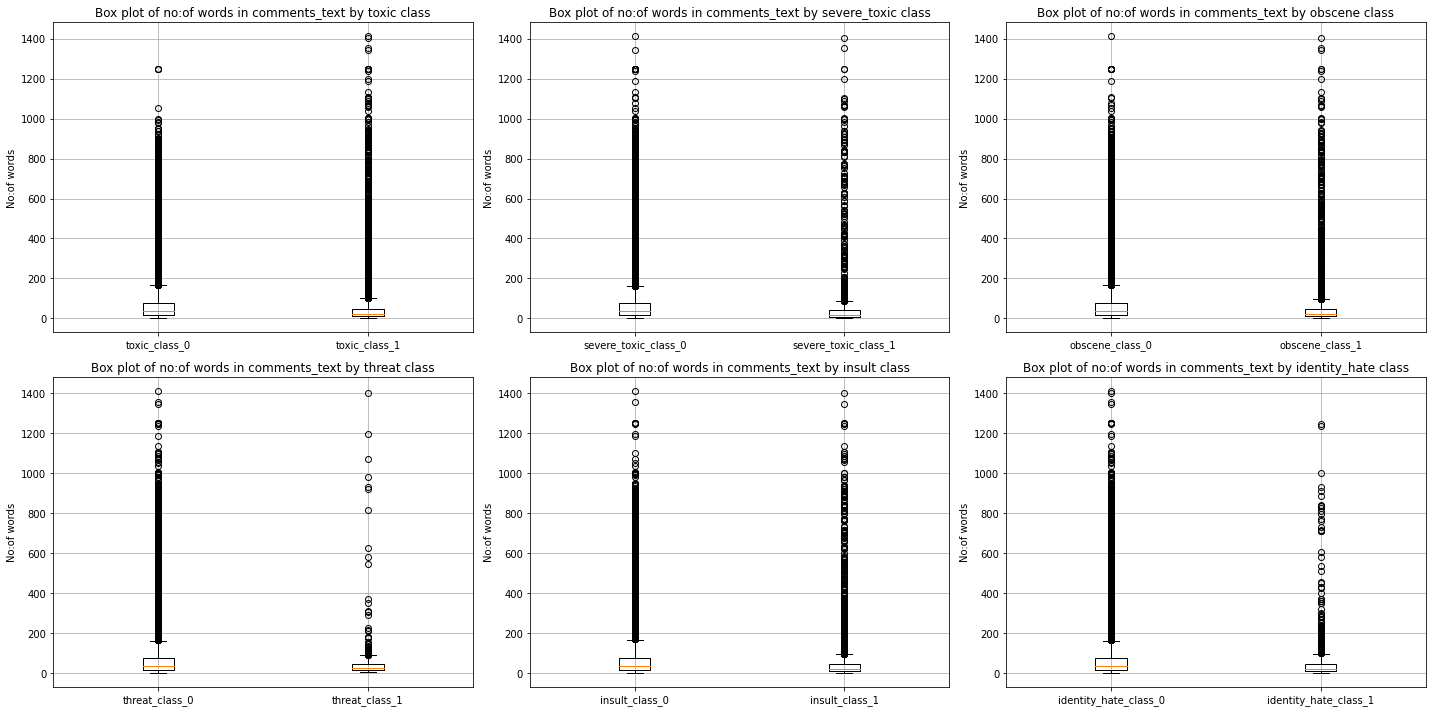

In [ ]:
class_0=[]
class_1=[]
plt.figure(figsize=(20,10))
count=1
for col in data.columns[2:]:
    toxic_class_0 = data[data[col]==0]['comment_text'].str.split().apply(len)
    toxic_class_0_count = toxic_class_0.values
    class_0.append(toxic_class_0_count)
    toxic_class_1 = data[data[col]==1]['comment_text'].str.split().apply(len)
    toxic_class_1_count = toxic_class_1.values
    class_1.append(toxic_class_1_count)

    plt.subplot(2,3,count)
    plt.boxplot([class_0[count-1], class_1[count-1]])
    plt.title('Box plot of no:of words in comments_text by '+str(col)+' class')
    plt.xticks([1,2],(str(col)+'_class_0',str(col)+'_class_1'))
    plt.ylabel('No:of words')
    plt.tight_layout()
    plt.grid()
    count=count+1
plt.show()

1) Height of Box plots on no: of words in comment_text for each targets labels, for each class is almost similar except for identity_hate and toxic labels.

2) All the target label's class-0 plots are thicker (due to overlapping) than its corresponding class-1 plots. As we have many points belongs to class-0 for a particular target.

3) There is much overlapping of 50th percentile, 75th percentile for class-0 and class-1 for most of target labels. So no:of words in comments_text may not be good feature in this case.

Let us plot the distributions (PDF) of no:of words in targets labels per each class.

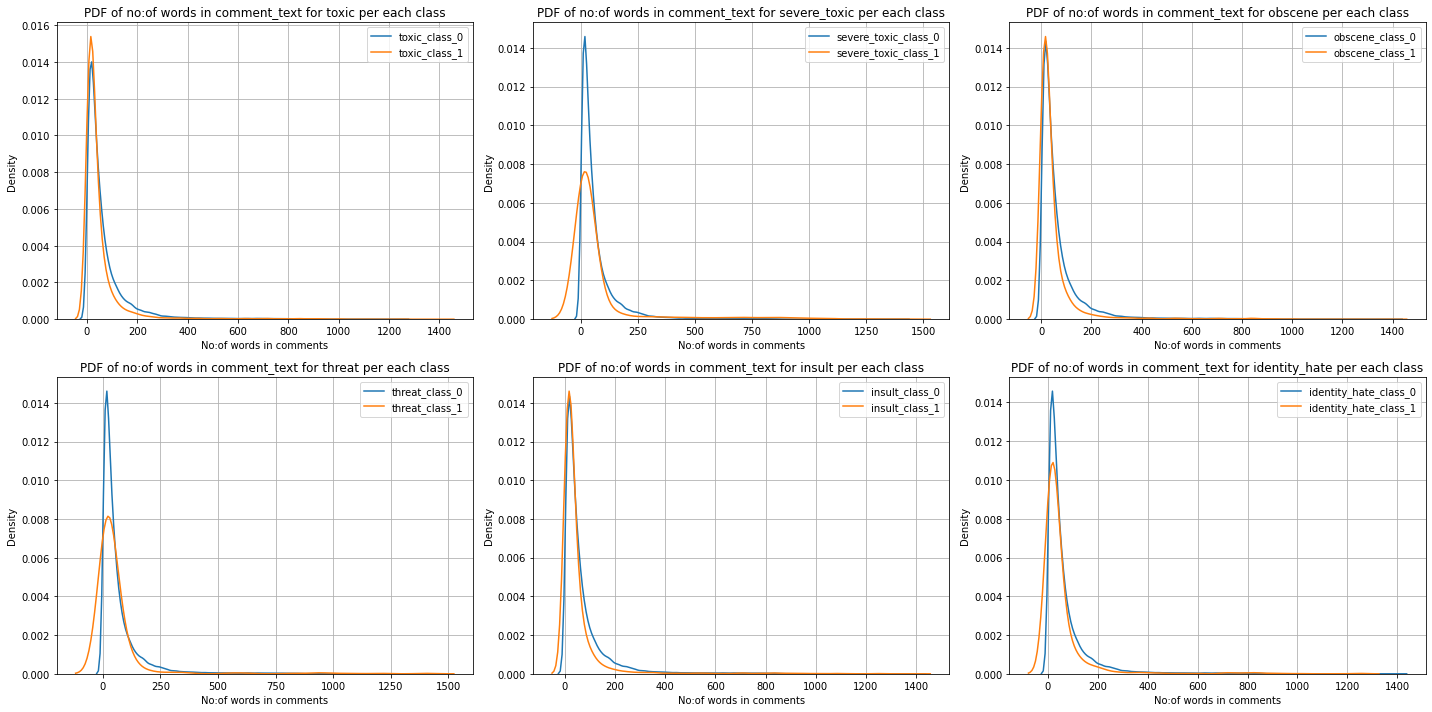

In [ ]:
plt.figure(figsize=(20,10))
count=1
for col in data.columns[2:]:
    plt.subplot(2,3,count)
    sns.distplot(class_0[count-1], hist=False, label=str(col)+'_class_0')
    sns.distplot(class_1[count-1], hist=False, label=str(col)+'_class_1')
    plt.title('PDF of no:of words in comment_text for '+str(col)+' per each class')
    plt.xlabel('No:of words in comments')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    count=count+1
plt.show()


1) Distribution of no: of words in comment_text for all the target labels per class is overalaping.

2) So, from above it is clear that there is no clear seperation between class-0/class-1 for any of the target labels.

3) Class-0 is dominating in most of the distribution plots. 


After all the study between no: of words in comment_text & target labels, it doesn't play any major role in classification as all of the density plots for toxic & non-toxic are overlapping each other.

### 4.12 Word Cloud

In this section, let us plot the word cloud on the comment_text feature in order to bring the most common/occuring word under each target and each class.

**Disclaimer: The dataset for this case-study contains text that may be considered profane, vulgar, or offensive.**

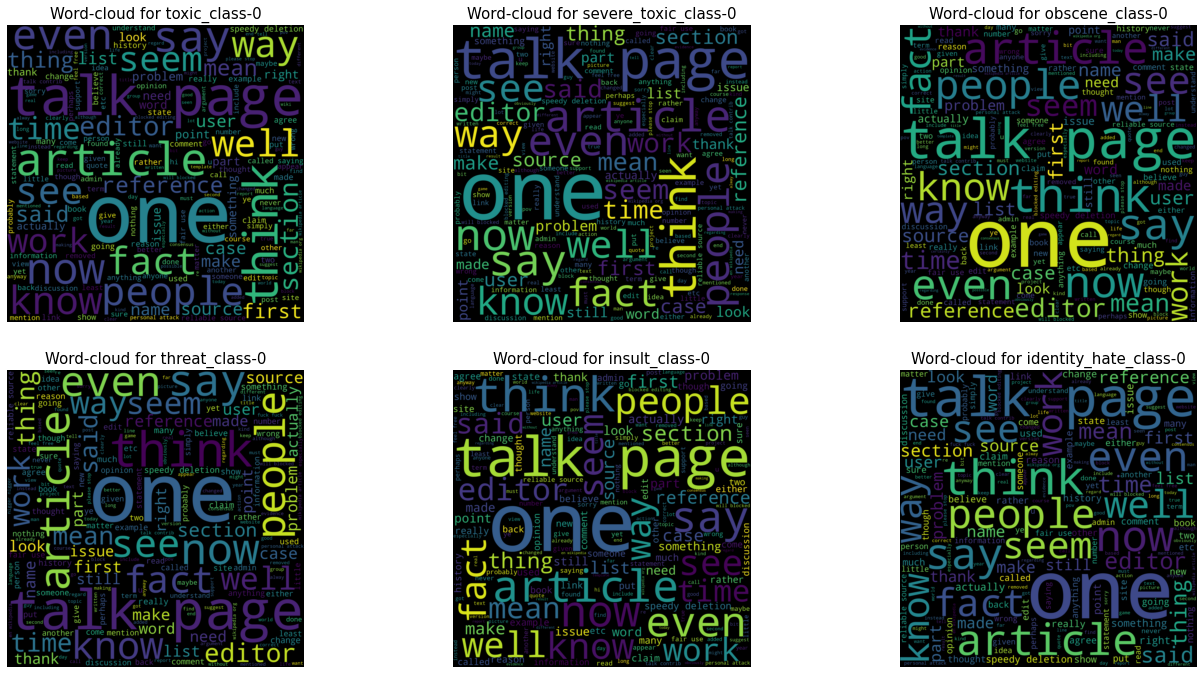

In [ ]:
#doc: https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud
plt.figure(figsize=(20,10))
count=1
for col in data.columns[2:]:
    toxic_class_0 = data[data[col]==0]['comment_text'].str.lower().values
    wordcloud = WordCloud(width=2000, height=2000,
                          background_color ='black', margin=1,
                          stopwords = STOPWORDS,
                          ).generate(" ".join(toxic_class_0))

    plt.subplot(2,3,count)
    plt.axis("off")
    plt.title("Word-cloud for "+col+"_class-0",fontsize=15)
    plt.tight_layout(pad=3)
    plt.imshow(wordcloud,interpolation='bilinear')
    count=count+1
plt.show()

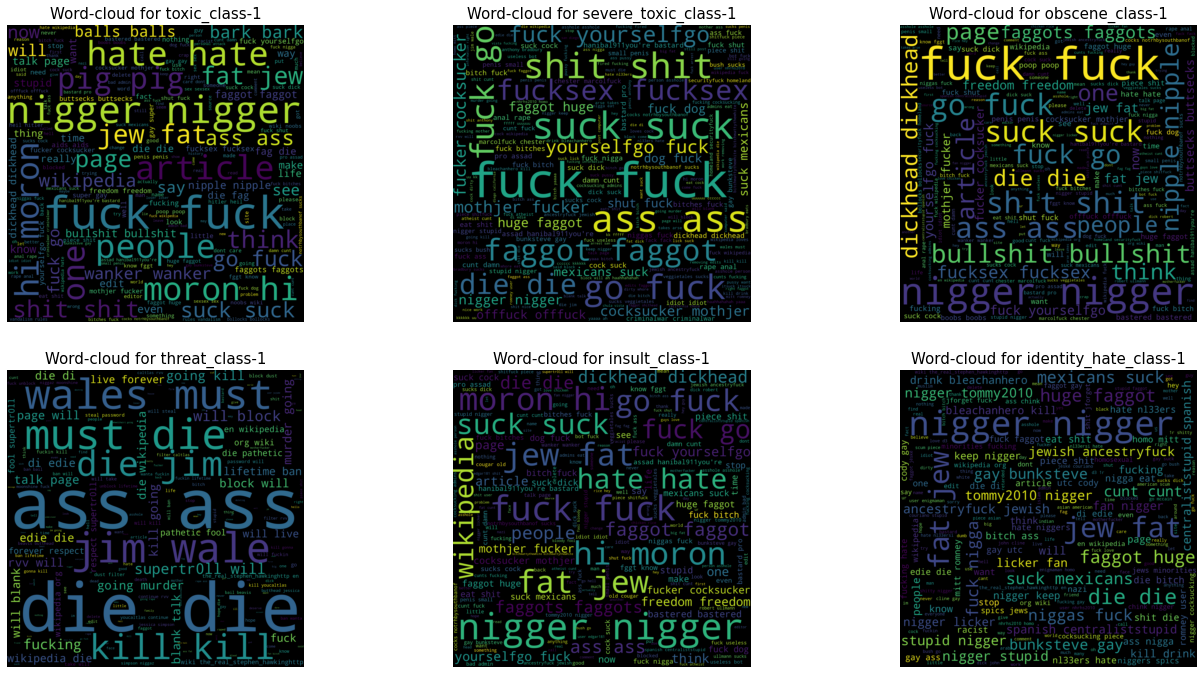

In [ ]:
#doc: https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud
plt.figure(figsize=(20,10))
count=1
for col in data.columns[2:]:
    toxic_class_1 = data[data[col]==1]['comment_text'].str.lower().values
    wordcloud = WordCloud(width=2000, height=2000,
                          background_color ='black', margin=1,
                          stopwords = STOPWORDS,
                          ).generate(" ".join(toxic_class_1))

    plt.subplot(2,3,count)
    plt.axis("off")
    plt.title("Word-cloud for "+col+"_class-1",fontsize=15)
    plt.tight_layout(pad=3)
    plt.imshow(wordcloud,interpolation='bilinear')
    count=count+1
plt.show()

## 5) Pre-Processing

In this section, lets pre-process the data, before feeding to the model. Since our input is text/string type, let's investigate and retain only useful information in the input text.

### Displaying Random Comments 

In [ ]:
#printing random comments from the data-set.

indices=np.random.randint(data.shape[0],size=5)

for i in indices:
    print(i,"--->",data['comment_text'].values[i])

120178 ---> "==Notability of Curious Crispy==
 A tag has been placed on Curious Crispy requesting that it be speedily deleted from Wikipedia. This has been done because the article appears to be about a real person, organization (band, club, company, etc.), or web content, but it does not indicate how or why the subject is notable: that is, why an article about that subject should be included in an encyclopedia. Under the criteria for speedy deletion, articles that do not indicate the subject's importance or significance may be deleted at any time. Please see the guidelines for what is generally accepted as notable. If this is the first page that you have created, then you should read the guide to writing your first article.

If you think that you can assert the notability of the subject, you may contest the deletion by adding  to the top of the page (just below the existing speedy deletion or ""db"" tag), coupled with adding a note on the article's talk page explaining your position, 

From above random samples, we can understand there are so many line breaks ("\n") and punctation marks,and some upper cased words,stop words,Decontractions, HTML tags, links etc. So lets clean all those unncessary words.

### Preprocessing Functions

In [ ]:
def convert_to_lower_case(text):

    """function to convert the input text to lower case"""
    
    return text.lower()

In [ ]:
def remove_escape_char(text):

    """function to remove newline (\n),
    tab(\t) and slashes (/ , \) from the input text"""

    return re.sub(r"[\n\t\\\/]"," ",text, flags=re.MULTILINE)

In [ ]:
def remove_html_tags(text):

    """function to remove html tags (< >) and its content 
    from the input text"""

    return re.sub(r"<.*>"," ",text, flags=re.MULTILINE)

In [ ]:
def remove_links(text):
    """function to remove any kind of links with no 
    html tags"""

    text= re.sub(r"http\S+"," ",text, flags=re.MULTILINE)

    return re.sub(r"www\S+"," ",text, flags=re.MULTILINE)

In [ ]:
def remove_digits(text):

    """function to remove digits from the input text"""

    return re.sub(r'\d'," ",text, flags=re.MULTILINE)

In [ ]:
def remove_punctuation(text):

    """function to remove punctuation marks from the input text"""

    for i in string.punctuation:
        text = text.replace(i," ")

    return text      

In [ ]:
def chuncking(text):

    """function to perform chucking, which is also referred as shallow parsing.
    This is useful in determing the parts of speech of a given text and adds more
    structure to the input data ."""

    """In this function, we use NLTK library to perform chuncking and if a 
    particular label is PERSON names, we remove that, and names of Geo-graphic
    ares are retained by adding _ in its words.ex-New_York"""


    chunks_data=[]
    chunks_data=(list(ne_chunk(pos_tag(word_tokenize(text)))))
    for label in chunks_data:
        if type(label)==Tree:
            if label.label() == "GPE":
                a = label.leaves()
                if len(a)>1:
                    gpe = "_".join([term for term,pos in a])
                    text = re.sub(rf'{a[1][0]}',gpe,text, flags=re.MULTILINE)
                    text = re.sub(rf'\b{a[0][0]}\b'," ",text, flags=re.MULTILINE)
            if label.label()=="PERSON":      
                for term,pog in label.leaves():
                    text = re.sub(re.escape(term)," ",text, flags=re.MULTILINE)
    return text

In [ ]:
def keep_alpha_and_underscore(text):

    """function to keep only aphabets and _ underscore, as we 
    added it in the chunking for geographic locations."""
    
    return re.sub(r"[^a-zA-Z_]"," ",text,flags=re.MULTILINE)

In [ ]:
def remove_extra_spaces_if_any(text):

    """function to remove extra spaces if any after all the pre-preocessing"""
    
    return re.sub(r" {2,}", " ", text, flags=re.MULTILINE)

In [ ]:
#on close observation of toxic comments, In some of the bad comments, words in 
#bad words characters are repeated. say for example...
#the word "shit" is written as SSSSHHHHHHHHIIIIIIIIIIITTTTTT
#but the base word is "shit", in order to increase model performance
# i am adding this.

def remove_repeated_characters(text):

    """function to remove repeated characters if any from the input text"""

    """for example CAAAAASSSSSSEEEEE SSSSTTTTTUUUUUUDDDDYYYYYY gives CASE STUDY"""

    return re.sub(r"(\w)(\1{2,})","\\1",text,flags=re.MULTILINE)


In [ ]:
#sample check
remove_repeated_characters("CAAAAASSSSSSEEEEE SSSSTTTTTUUUUUUDDDDYYYYYY")

'CASE STUDY'

In [ ]:
def remove_words_lesth2(text):
    """function to remove words with length less than 2"""

    text = re.sub(r'\b\w{1,2}\b'," ",text)
    
    return text

In [ ]:
def decontraction(text):

    """function to handle contraction errors"""
    res=""
    for word in text.split():
        try:
            con_text=contractions.fix(word)
            if con_text.lower() is word.lower():
                res=res+word+" "
            else:
                res=res+con_text+" "
        
        except:
            con_text=contractions.fix(word.lower())
            if con_text.lower() is word.lower():
                res=res+word+" "
            else:
                res=res+con_text+" "
    return res.strip()

### Stop-Words

Stop words means, which doesn't carry any importance in classification task. ie., words which are most occuring in the data-set and doesnt carry any importance in classifying either a positive/negative class. words like the, i , he, she, we, our, his, her, it, a , an, in, of, one, two, three, four, etc

In [ ]:
#supporting/essential downloads for NLTK library 
#to handle chuncking/stemming/stopwords

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [ ]:
#printing stop words from NLTK library in a readable format

stop_words=stopwords.words('english')
display_length=10

for i in range(int(np.ceil(len(stop_words)/display_length))):
    print(stop_words[i*display_length:(i+1)*display_length])


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]
["you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his']
['himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself']
['they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this']
['that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be']
['been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing']
['a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until']
['while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into']
['through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down']
['in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once']
['here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each']
['few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only']
['own', 'same', 'so

In [ ]:
#printing stop words from Word Cloud library in a readable format

display_length=10
word_cloud_stp_wrds=list(STOPWORDS)
for i in range(int(np.ceil(len(list(word_cloud_stp_wrds))/display_length))):
    print(word_cloud_stp_wrds[i*display_length:(i+1)*display_length])

['shall', 'she', 'too', 'through', "hadn't", "i'm", "i'd", 'about', "don't", 'at']
['during', 'again', "weren't", "doesn't", 'some', 'get', 'yours', 'until', 'itself', 'can']
['between', "it's", 'ourselves', 'down', "didn't", 'with', 'her', 'themselves', 'have', 'that']
['and', 'of', "isn't", 'those', 'such', 'could', 'theirs', "wasn't", 'any', 'each']
['into', 'why', "you'll", 'then', 'is', 'them', 'once', 'however', 'www', 'than']
['against', 'or', 'k', 'as', "we've", 'which', "haven't", 'http', 'above', 'else']
['the', "we're", "won't", 'more', 'me', "they'll", "you've", 'no', "mustn't", 'for']
["he'd", 'being', "she'd", 'their', 'from', 'while', 'he', 'by', "here's", "i've"]
['did', 'has', 'where', 'also', 'further', 'myself', 'him', "shouldn't", 'whom', 'otherwise']
['like', "he'll", 'his', "when's", 'own', 'you', 'both', 'himself', "let's", "there's"]
['they', 'are', 'all', 'before', "they'd", "they're", "couldn't", 'ever', 'would', 'under']
["she'll", 'yourselves', "she's", 'her

In [ ]:
#lets take all the stop words from both NLTK & Word Cloud libraries, along 
# with some custom words

final_stop_words=list(STOPWORDS.union(set(stop_words)))
final_stop_words.extend(["mr","mrs","miss",
                        "one","two","three","four","five",
                        "six","seven","eight","nine","ten",
                        "us","also","dont","cant","any","can","along",
                        "among","during","anyone",
                         "a","b","c","d","e","f","g","h","i","j","k","l","m",
                         "n","o","p","q","r","s","t","u","v","w","x","y","z","hi","hello","hey","ok",
                         "okay","lol","rofl","hola","let","may","etc"])

display_length=10

for i in range(int(np.ceil(len(final_stop_words)/display_length))):
    print(final_stop_words[i*display_length:(i+1)*display_length])

["should've", 'through', "hadn't", "i'd", 'about', 'at', 'again', "weren't", "doesn't", 'get']
['yours', 'itself', "didn't", 'ma', "wasn't", 'each', 'then', 'is', 'them', 'once']
['however', 'www', 'against', 'k', 'as', 'which', "haven't", 'above', 'else', "we're"]
["won't", 'more', "they'll", "you've", "mustn't", "she'd", 'from', "here's", "i've", 'did']
['also', 'wasn', "shouldn't", 'whom', 'otherwise', "mightn't", "he'll", 'mightn', 'his', 'own']
['you', 'y', "let's", 'all', 'before', 'o', "couldn't", 'ever', 'would', 'll']
['haven', "she'll", 'yourselves', "we'd", 'other', 'am', 'weren', 'needn', 'your', 'r']
['not', 'isn', 'wouldn', 'didn', 've', 'herself', 'our', 'yourself', 'its', 'in']
['nor', "what's", 'cannot', 'since', 'd', 'because', 'mustn', 'hadn', 'but', "wouldn't"]
['ain', 'only', "shan't", 'ought', 'off', "how's", 'an', 'same', "that's", 'won']
['these', "i'll", "where's", "aren't", "you'd", 'a', 'having', "who's", 'who', "she's"]
['my', 'shall', 'she', 'will', 'too', 

### Lemmatization

Lemmatization is the process of grouping different forms of words in to a single word. Lemmatization and stemming are similar. But Lemmatization brings the meaning to the context and morphological analysis.

For Example

Good--> Better--> Best  all are based on the word "Good"

Dogs--> Dog

Apples--> Apple

In [ ]:
lemmatiser = WordNetLemmatizer()

### One-function Pre-processing

Defining the one-step preprocessing function to perform all the different  pre-processing steps discussed above.

In [ ]:
# one pre-processing function

def preprocess(text):

    preprocessed_text = []

    for each_text in tqdm(text):

        result=remove_links(each_text)
        result=remove_html_tags(result)
        result=remove_escape_char(result)        
        result=remove_digits(result)
        result=decontraction(result)
        result=remove_punctuation(result)
        result=chuncking(result)
        result=convert_to_lower_case(result)
        result = ' '.join(non_stop_word for non_stop_word in result.split() if non_stop_word not in final_stop_words)
        result=keep_alpha_and_underscore(result)
        result=remove_extra_spaces_if_any(result)
        result=remove_repeated_characters(result)
        result=remove_words_lesth2(result)
        result=' '.join(lemmatiser.lemmatize(word,pos="v") for word in result.split())
        preprocessed_text.append(result.strip())
        
    return preprocessed_text

In [ ]:
#printing random pre-processed data

#see index 90099 for chuncking example

indices=np.random.randint(len(data['comment_text'].values),size=5)
indices= np.append(indices,90099)

for i in indices:
    print(i," - Original Text ---> ",data['comment_text'].values[i])
    print(i," - Processed Text ---> ",preprocess([data['comment_text'].values[i]]))
    print("="*270)

108014  - Original Text --->  Oppose,  should redirect to Automobile per WP:PRIMARYTOPIC.



108014  - Processed Text --->  ['oppose redirect automobile per primarytopic']
81516  - Original Text --->  Hello, you used the  tag but you did not post a question. Please write out your question and when you are done, place back the tag. I or someone else will be along to help. Alternatively, you can join the #wikipedia-en-help IRC help channel to get real-time assistance. (Click here for instant access).



81516  - Processed Text --->  ['use tag post question please write question do place back tag someone help alternatively join wikipedia help irc help channel real time assistance instant access']
86659  - Original Text --->  also disambiguation links [] all good.



86659  - Processed Text --->  ['disambiguation link good']
142530  - Original Text --->  "    in past 100 years pashtun ruler keep the Hazara under control and never let a honest and fear accontinlity to see how many Hazara are, i am hazara myself and i can tell you that there are more the 16M  hazara in the world and more then 8M hazara live only in Afghanistan, is that not enough that i am hazara and telling you that to not change the numbers,so lets be honest and dont change your from Pakistan believing other people acoountnility not the accountbility of Hazara that keep telling you we are more then 16M and you don't believe,  WOW WHAT A WORLD WE LIVE,"""



142530  - Processed Text --->  ['past years pashtun ruler keep hazara control never honest fear accontinlity see many hazara hazara tell hazara world hazara live afghanistan enough hazara tell change number honest change pakistan believe people acoountnility accountbility hazara keep tell believe wow world live']
102108  - Original Text --->  Date 

Hi there, was just passin' by your userpage and I saw you weren't sure of exactly when you joined Wikipedia. Well, I'll have to look in a bit further to see when exactly you joined, but I do know that you made your first edit on 15:20, 11 August 2005. Hope that helps! Cheers,  Your will is mine.



102108  - Processed Text --->  ['date passin userpage saw sure exactly join well look bite see exactly join know make first edit august hope help mine']
90099  - Original Text --->  , inspired President of the United States to change his name to Barack Hussein Obama.



90099  - Processed Text --->  ['inspire president united_states change name']


In [ ]:
#performing the pre-processing on all the comments in the data-set
preprocessed_data = preprocess(data['comment_text'].values)

In [ ]:
#printing random pre-processed data

indices=np.random.randint(len(preprocessed_data),size=5)

for i in indices:
    print(i," - Original Text ---> ",data['comment_text'].values[i])
    print(i," - Processed Text ---> ",preprocessed_data[i])
    print("="*270)

10472  - Original Text --->  Croke Park is a GAA arena but since it falls into cat. 2, I propose that it be removed once the Ariva stadium is complete
10472  - Processed Text --->  park gaa arena fall cat propose remove ariva stadium complete
156471  - Original Text --->  "

""Mine is the true revolutionary method. If the people of the empire refuse, as I believe they should refuse, to render military service - if they decline to pay taxes to support that instrument of violence, an army - the present system of government cannot stand."" - Tolstoy

RJ11, in the quote you gave, Tolstoy answered, ""No; he ought not voluntarily to pay taxes.""  So he did support tax resistence.  I think you have misunderstood the rest of the quote due to the non-standard use (or translation from Russian?) of the word ""resist."" (which is understandable, unless you'd read the book.)  In ""The Kingdom..."" the word ""resist"" means the use of violence or evil.  I.e. chapter 1 title: ""THE DOCTRINE OF NON-RE

In [ ]:
clean_data=data.drop(columns=["id"])
clean_data['comment_text']=preprocessed_data
clean_data.sample(5)

comment_text  ...  identity_hate
152558  personal imformation article virgin record wri...  ...              0
20433   try remember log point try pick fight balkanfe...  ...              0
26459   information insert gov site document political...  ...              0
107981  speedy deletion idiots convention tag place id...  ...              0
148895  know cite coolac massacre last monday around a...  ...              0

[5 rows x 7 columns]

In [ ]:
clean_data.to_csv("/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/pre_processed_data.csv",
          header=True, index=False)

Completed the pre-processing. Lets us convert these text features into Vectors in the Next section.

## 6) Featurization

In this section, let us convert text features into vectors ie vectorization. In order to avoid data leackage, let's split the whole data set into train and test data sets and then apply the vectorization.

#### Empty/NAN Comments in Pre-Processed Data

After cleaning some of the comments are empty, lets investigate on this.

In [ ]:
clean_data=pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/pre_processed_data.csv")

In [ ]:
clean_data.isnull().values.any()

True

In [ ]:
index=clean_data[clean_data['comment_text'].isnull()].index

In [ ]:
len(index)

379

In [ ]:
sample=np.random.choice(index,5)

for i in sample:
    print(i,"- index data before pre-processing-->",data['comment_text'].values[i])
    print(i,"- index data after pre-processing-->",clean_data['comment_text'].values[i])
    print("="*100)


123442 - index data before pre-processing--> http://www.mediamonitors.net/edna47.html   http://www.freerepublic.com/forum/a3ad7b207707d.htm
123442 - index data after pre-processing--> nan
46172 - index data before pre-processing--> Also https://meta.wikimedia.org/wiki/Special:CentralAuth/Bbjalvin
46172 - index data after pre-processing--> nan
63891 - index data before pre-processing--> "Oh, and, who or what is ""Sampolit"", is that you? "
63891 - index data after pre-processing--> nan
150039 - index data before pre-processing--> LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL LOL L

most of the comments contains purely numbers, stop-words and links. so, in pre-processing all these unwanted data has been cleaned and no data exists in that comments.that is why we have nan/nulls in the cleaned data.

so lets elimate those empty/Nan data.

In [ ]:
clean_data.dropna(inplace=True)

In [ ]:
clean_data.isnull().values.any()

False

In [ ]:
clean_data.shape

(159192, 7)

In [ ]:
clean_data.to_csv("/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/pre_processed_data_no_nan.csv",
          header=True, index=False)

### Splitting Data-set

In [ ]:
clean_data=pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/pre_processed_data_no_nan.csv")

In [ ]:
clean_data.shape

(159192, 7)

In [ ]:
clean_data.sample(3)

comment_text  ...  identity_hate
30418   tag place request speedily delete wikipedia do...  ...              0
87986   request arbitration comment wherever seem appr...  ...              0
129060  yes wrong dyer expert ignorant make laugh talk...  ...              0

[3 rows x 7 columns]

In [ ]:
X=clean_data['comment_text']
y=clean_data.drop(columns=['comment_text'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, 
                                        random_state=42, shuffle=True)

In [ ]:
print("Shape of X-Train",X_train.shape)
print("Shape of X-Test",X_test.shape)
print("Shape of y-Train",y_train.shape)
print("Shape of y-Test",y_test.shape)

Shape of X-Train (111434,)
Shape of X-Test (47758,)
Shape of y-Train (111434, 6)
Shape of y-Test (47758, 6)


In [ ]:
def change_y(data):

    """"function to convert multiple y labels as single y label"""
    #this is done to plot T-SNE
    res=[]
    for row in data:
        if (sum(row)==0):
            res.append(0)
        else:
            res.append(1)
    return np.array(res)

In [ ]:
y_train_tsne=change_y(y_train.values)
y_test_tsne=change_y(y_test.values)
#converting multi y label to single y label
print("Shape of y-Train",y_train_tsne.shape)
print("Shape of y-Test",y_test_tsne.shape)

Shape of y-Train (111434,)
Shape of y-Test (47758,)


### Vectorization using TF-IDF

Now Let us convert text features into numerical representation. We have various featurizing techniques/algorthms to acheive the same. Here we are using TF-IDF. 


#### Uni Grams

In [ ]:
#Vectorizing essay feature (text) with TF-IDF

vectorizer = TfidfVectorizer(min_df=10,max_features=10000,ngram_range=(1,1),stop_words=final_stop_words)

vectorizer.fit(X_train.values)

# test datacorpus need to be transformed using train vocabulary
X_train_tfidf_uni = vectorizer.transform(X_train.values)

X_test_tfidf_uni = vectorizer.transform(X_test.values)

In [ ]:
#finding the top TF-IDF values/words per class with uni-grams data.

top_tf_idf_val=[]
for col in tqdm(y_train.columns):
    index=y_train[y_train[col]==1].index
    filtered_data=X_train.loc[index]
    vec_data=vectorizer.transform(filtered_data)
    vec_data=vec_data.A

    #finding the indices of top TF-IDF values across the output

    indices=np.dstack(np.unravel_index(np.argsort(vec_data.ravel()), vec_data.shape))[0][::-1]
    feat=vectorizer.get_feature_names()
    avg_tf_idf_scores=dict()

    for index in indices:
        if feat[index[1]] in avg_tf_idf_scores:
            value=avg_tf_idf_scores[feat[index[1]]]
            value.append(vec_data[index[0]][index[1]])
            avg_tf_idf_scores[feat[index[1]]]=value
        else:
            avg_tf_idf_scores[feat[index[1]]]=[vec_data[index[0]][index[1]]]

    # TF-IDF value is not same for the same word. as it is depends on 
    #TF value and IDF value
    #TF value will change based on the input. so finding average TF-IDF value

    for key in avg_tf_idf_scores:

        value=np.array(avg_tf_idf_scores[key])
        avg_tf_idf_scores[key]= np.mean(value)

    avg_tf_idf_scores={k: v for k, v in sorted(avg_tf_idf_scores.items(),
                                    key=lambda item: item[1],reverse=True)}

    top_tf_idf_val.append((list(avg_tf_idf_scores.keys()),list(avg_tf_idf_scores.values())))

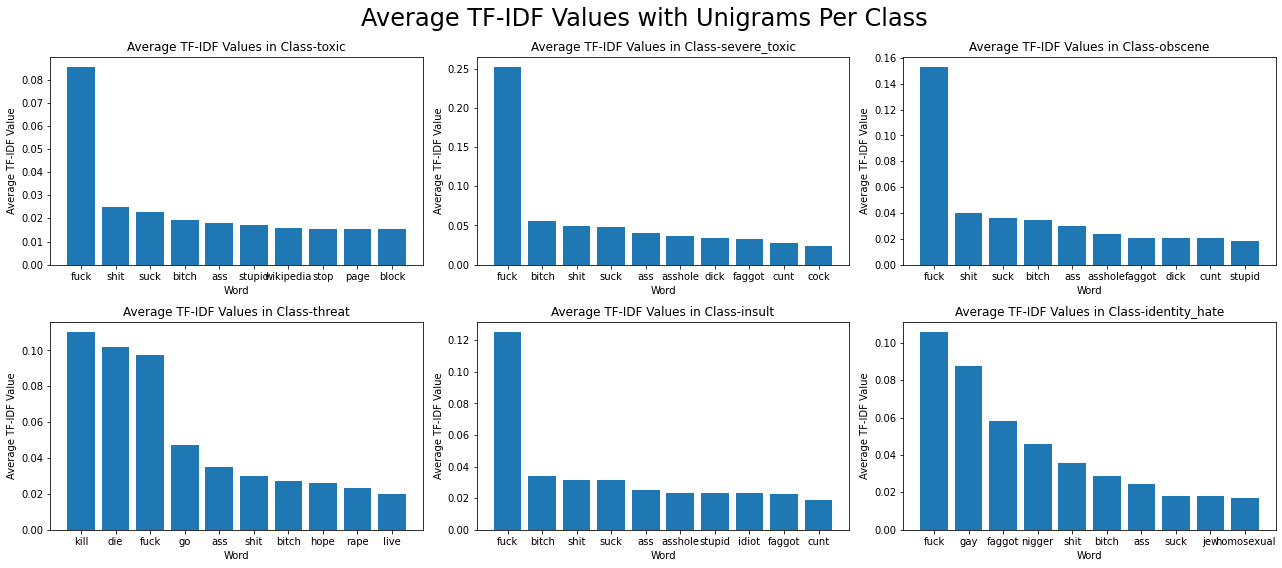

In [ ]:
#Plotting the average TF-IDF Value with Uni-gram Per class
fig, axs = plt.subplots(2,3,figsize=(18,8))
fig.suptitle("Average TF-IDF Values with Unigrams Per Class",fontsize=24)
axs=axs.flatten()
for data,ax,col in zip(top_tf_idf_val,axs,y_train.columns):
    words=data[0][:10]
    avg_tf_idf_value=data[1][:10]    
    rects1 = ax.bar(words, avg_tf_idf_value)
    ax.set_ylabel('Average TF-IDF Value')
    ax.set_xlabel("Word")
    ax.set_title('Average TF-IDF Values in Class-'+str(col))
fig.tight_layout()
plt.show()

The above figure is the average TF-IDF values on uni-gram data.

As it is observed that the repetative words that are seen in the word cloud has the highest Average TF-IDF Values per class.  

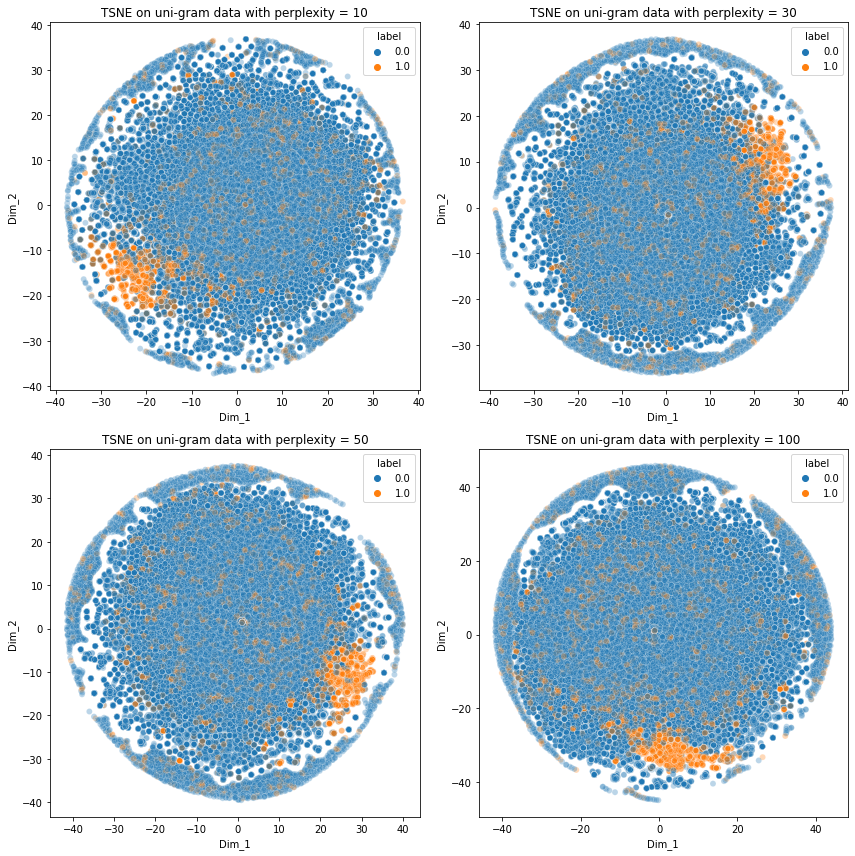

In [ ]:
perplexity_list=[10,30,50,100]

fig,axs=plt.subplots(2,2,figsize=(12,12))

axs=axs.flatten()
for per,ax in zip(perplexity_list,axs):

    model = TSNE(n_components=2, random_state=0, perplexity=per,n_jobs=-1)
    tsne_data = model.fit_transform(X_train_tfidf_uni) 

    # creating a new data fram which help us in ploting the result data
    tsne_data = np.vstack((tsne_data.T, y_train_tsne)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
    ax.set_title("TSNE on uni-gram data with perplexity = "+str(per))
    sns.scatterplot(x="Dim_1", y="Dim_2",hue="label",
    data=tsne_df,legend="full",alpha=0.3,ax=ax)

fig.tight_layout()
plt.show()

As our data set is highly imbalanced and we have high Non-Toxic comments than Toxic comments.

1) Above is the T-SNE for the Uni-gram data and the Toxic and Non Toxic comments grouped with some overlapping.

2) And also Non Toxic clusters having Toxic points at the random 

3) Different Perpelexity values gave more or less the similar results

#### Bi Grams

In [ ]:
#Vectorizing essay feature (text) with TF-IDF

vectorizer = TfidfVectorizer(min_df=10,max_features=10000,ngram_range=(2,2),stop_words=final_stop_words)

vectorizer.fit(X_train.values)

# test datacorpus need to be transformed using train vocabulary
X_train_tfidf_bi = vectorizer.transform(X_train.values)

X_test_tfidf_bi = vectorizer.transform(X_test.values)


In [ ]:
#finding the top TF-IDF values/words per class with bi-grams data.

top_tf_idf_val=[]
for col in tqdm(y_train.columns):
    index=y_train[y_train[col]==1].index
    filtered_data=X_train.loc[index]
    vec_data=vectorizer.transform(filtered_data)
    vec_data=vec_data.A

    #finding the indices of top TF-IDF values across the output

    indices=np.dstack(np.unravel_index(np.argsort(vec_data.ravel()), vec_data.shape))[0][::-1]
    feat=vectorizer.get_feature_names()
    avg_tf_idf_scores=dict()

    
    for index in indices:
        if feat[index[1]] in avg_tf_idf_scores:
            value=avg_tf_idf_scores[feat[index[1]]]
            value.append(vec_data[index[0]][index[1]])
            avg_tf_idf_scores[feat[index[1]]]=value
        else:
            avg_tf_idf_scores[feat[index[1]]]=[vec_data[index[0]][index[1]]]

    # TF-IDF value is not same for the same word. as it is depends on 
    #TF value and IDF value
    #TF value will change based on the input. so finding average TF-IDF value

    for key in avg_tf_idf_scores:

        value=np.array(avg_tf_idf_scores[key])
        avg_tf_idf_scores[key]= np.mean(value)

    avg_tf_idf_scores={k: v for k, v in sorted(avg_tf_idf_scores.items(),
                                    key=lambda item: item[1],reverse=True)}

    top_tf_idf_val.append((list(avg_tf_idf_scores.keys()),list(avg_tf_idf_scores.values())))

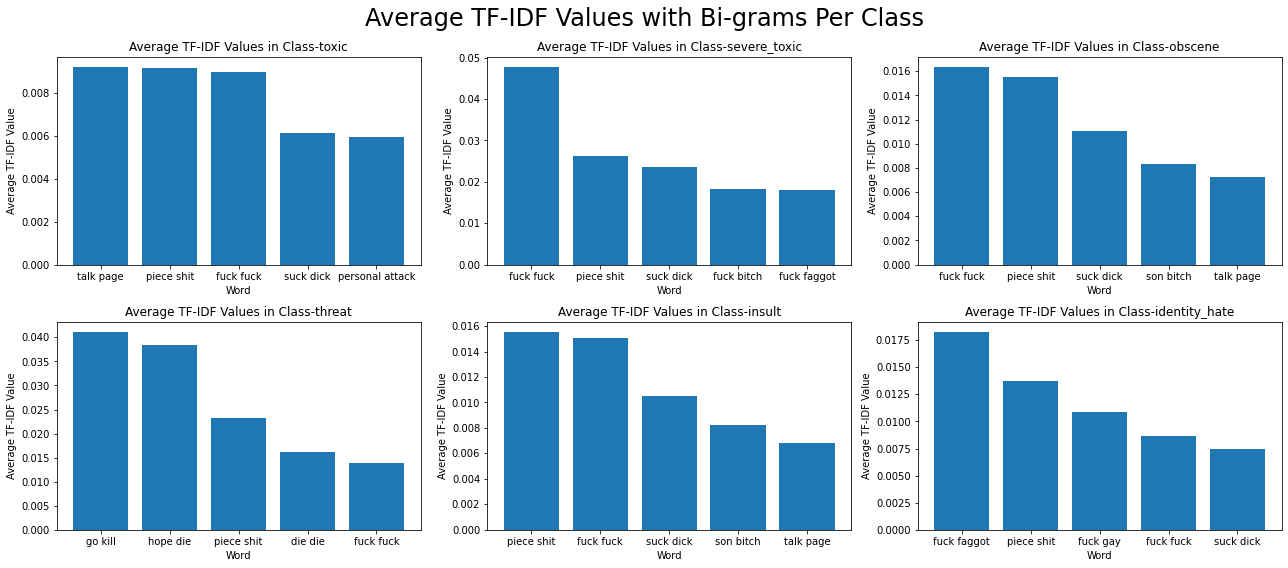

In [ ]:
#Plotting the Average TF-IDF value per class with Bi gram data
fig, axs = plt.subplots(2,3,figsize=(18,8))
fig.suptitle("Average TF-IDF Values with Bi-grams Per Class",fontsize=24)
axs=axs.flatten()
for data,ax,col in zip(top_tf_idf_val,axs,y_train.columns):
    words=data[0][:5]
    avg_tf_idf_value=data[1][:5]    
    rects1 = ax.bar(words, avg_tf_idf_value)
    ax.set_ylabel('Average TF-IDF Value')
    ax.set_xlabel("Word")
    ax.set_title('Average TF-IDF Values in Class-'+str(col))
fig.tight_layout()
plt.show()

The above figure is the average TF-IDF values on bi-gram data.

As it is observed that the repetative words that are seen in the word cloud has the highest Average TF-IDF Values per class. 

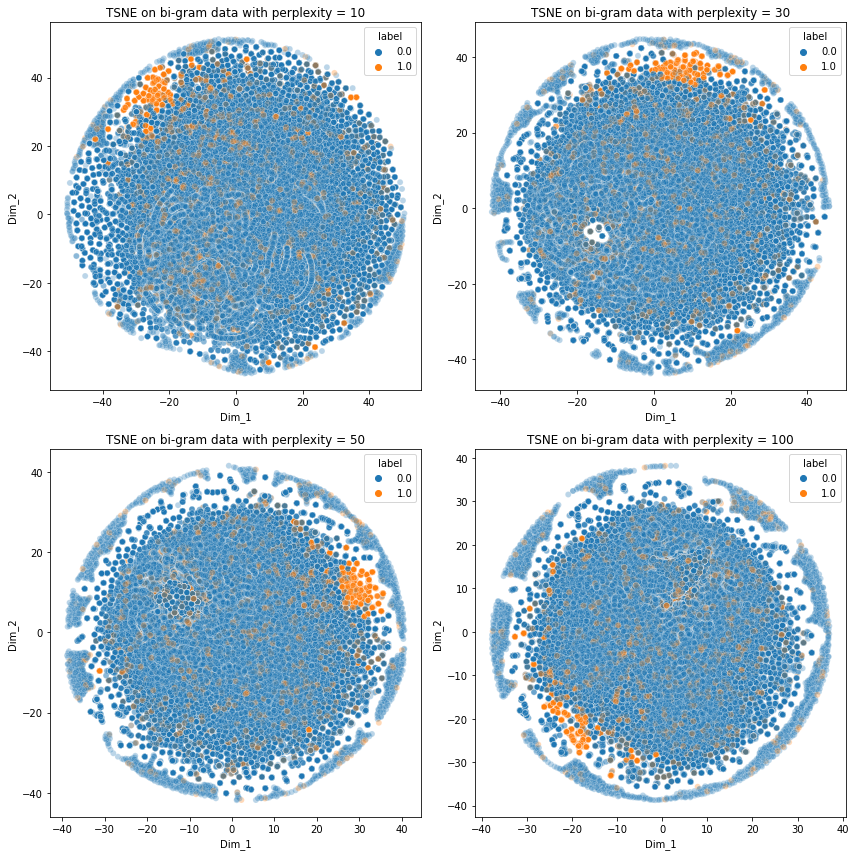

In [ ]:
perplexity_list=[10,30,50,100]

fig,axs=plt.subplots(2,2,figsize=(12,12))

axs=axs.flatten()
for per,ax in zip(perplexity_list,axs):

    model = TSNE(n_components=2, random_state=0, perplexity=per,n_jobs=-1)
    tsne_data = model.fit_transform(X_train_tfidf_bi) 

    # creating a new data fram which help us in ploting the result data
    tsne_data = np.vstack((tsne_data.T, y_train_tsne)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
    ax.set_title("TSNE on bi-gram data with perplexity = "+str(per))
    sns.scatterplot(x="Dim_1", y="Dim_2",hue="label",
    data=tsne_df,legend="full",alpha=0.3,ax=ax)

fig.tight_layout()
plt.show()


1) Above is the T-SNE for the bi-gram data and the Toxic and Non Toxic comments grouped with some overlapping.

2) And also Non Toxic clusters having Toxic points at the random 

3) Different Perpelexity values gave more or less the similar results

#### Tri Grams

In [ ]:
#Vectorizing essay feature (text) with TF-IDF

vectorizer = TfidfVectorizer(min_df=10,max_features=10000,ngram_range=(3,3),stop_words=final_stop_words)

vectorizer.fit(X_train)

# test datacorpus need to be transformed using train vocabulary
X_train_tfidf_tri = vectorizer.transform(X_train)

X_test_tfidf_tri = vectorizer.transform(X_test)


In [ ]:
#finding the top TF-IDF values/words per class with tri-grams data.

top_tf_idf_val=[]
for col in tqdm(y_train.columns):
    index=y_train[y_train[col]==1].index
    filtered_data=X_train.loc[index]
    vec_data=vectorizer.transform(filtered_data)
    vec_data=vec_data.A

    #finding the indices of top TF-IDF values across the output
    
    indices=np.dstack(np.unravel_index(np.argsort(vec_data.ravel()), vec_data.shape))[0][::-1]
    feat=vectorizer.get_feature_names()
    avg_tf_idf_scores=dict()

    for index in indices:
        if feat[index[1]] in avg_tf_idf_scores:
            value=avg_tf_idf_scores[feat[index[1]]]
            value.append(vec_data[index[0]][index[1]])
            avg_tf_idf_scores[feat[index[1]]]=value
        else:
            avg_tf_idf_scores[feat[index[1]]]=[vec_data[index[0]][index[1]]]

    # TF-IDF value is not same for the same word. as it is depends on 
    #TF value and IDF value
    #TF value will change based on the input. so finding average TF-IDF value

    for key in avg_tf_idf_scores:

        value=np.array(avg_tf_idf_scores[key])
        avg_tf_idf_scores[key]= np.mean(value)

    avg_tf_idf_scores={k: v for k, v in sorted(avg_tf_idf_scores.items(),
                                    key=lambda item: item[1],reverse=True)}

    top_tf_idf_val.append((list(avg_tf_idf_scores.keys()),list(avg_tf_idf_scores.values())))

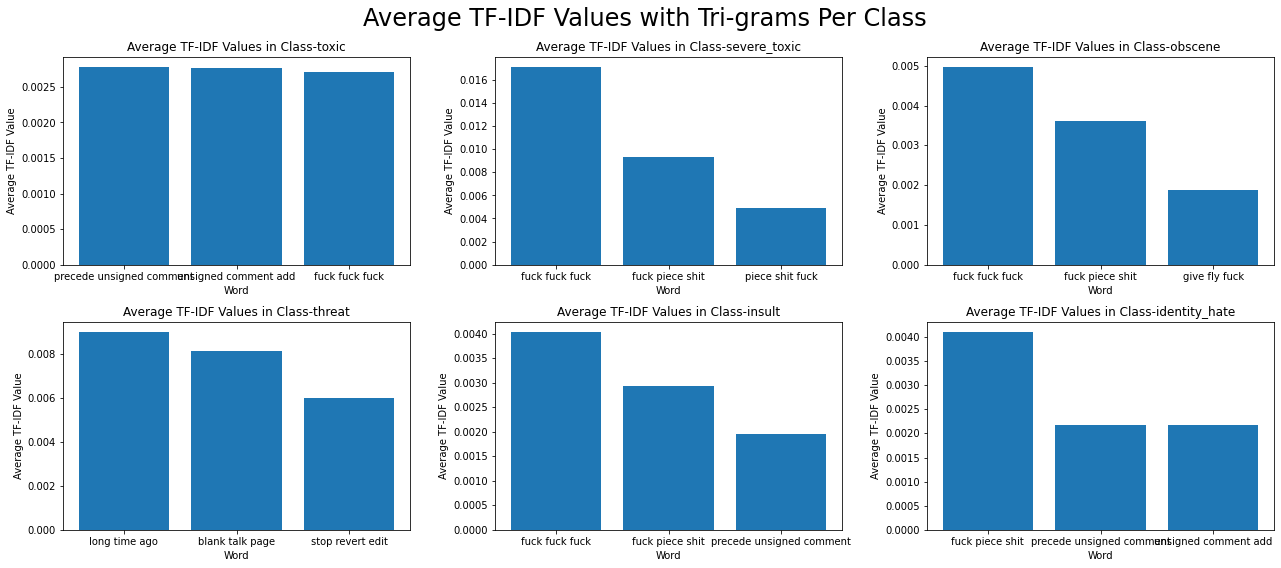

In [ ]:
#plotting the Average TF-IDF Values per class with Tri-Gram data 
fig, axs = plt.subplots(2,3,figsize=(18,8))
fig.suptitle("Average TF-IDF Values with Tri-grams Per Class",fontsize=24)
axs=axs.flatten()
for data,ax,col in zip(top_tf_idf_val,axs,y_train.columns):
    words=data[0][:3]
    avg_tf_idf_value=data[1][:3]    
    rects1 = ax.bar(words, avg_tf_idf_value)
    ax.set_ylabel('Average TF-IDF Value')
    ax.set_xlabel("Word")
    ax.set_title('Average TF-IDF Values in Class-'+str(col))
fig.tight_layout()
plt.show()

The above figure is the average TF-IDF values on tri-gram data.

As it is observed that the repetative words that are seen in the word cloud has the highest Average TF-IDF Values per class. 

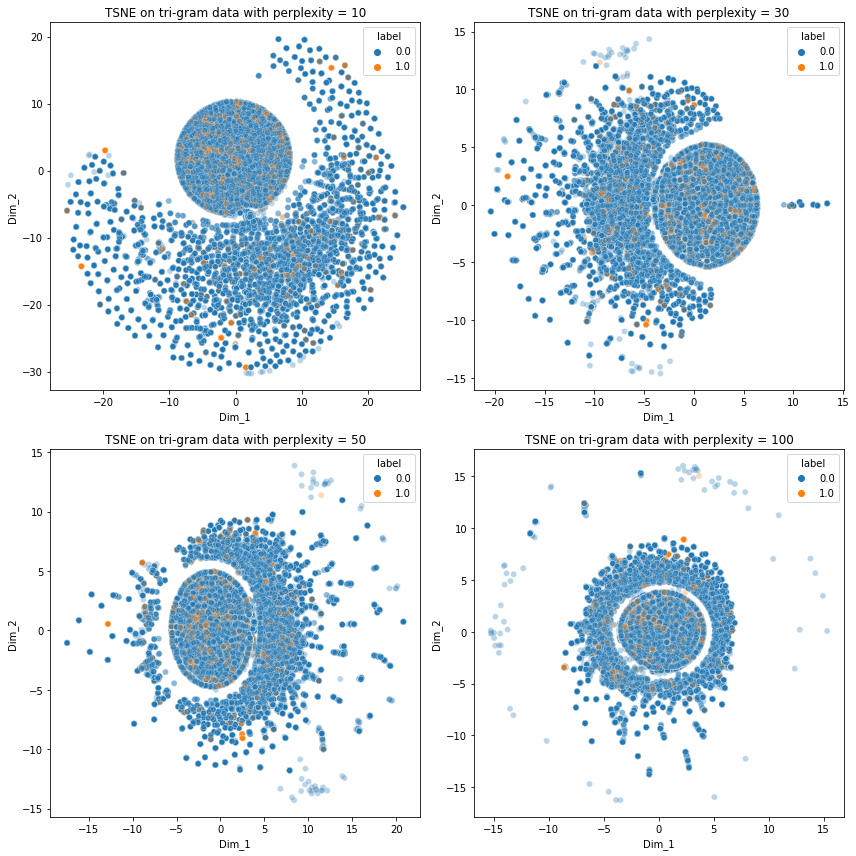

In [ ]:
perplexity_list=[10,30,50,100]

fig,axs=plt.subplots(2,2,figsize=(12,12))

axs=axs.flatten()
for per,ax in zip(perplexity_list,axs):

    model = TSNE(n_components=2, random_state=0, perplexity=per,n_jobs=-1)
    tsne_data = model.fit_transform(X_train_tfidf_tri) 

    # creating a new data fram which help us in ploting the result data
    tsne_data = np.vstack((tsne_data.T, y_train_tsne)).T
    tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))
    ax.set_title("TSNE on tri-gram data with perplexity = "+str(per))
    sns.scatterplot(x="Dim_1", y="Dim_2",hue="label",
    data=tsne_df,legend="full",alpha=0.3,ax=ax)

fig.tight_layout()
plt.show()


1) Above is the T-SNE for the Tri-gram data and the Toxic and Non Toxic comments grouped with most overlapping. 

2) There is no clear seperations of clusters.

3) With different perplexity values gave disimilar results.

### Vectorization using TF-IDF weighted Avg W2V

TF-IDF is unable to catch the scemantic meanings in a given input. so we will be using TF-IDF weighted Avg W2V for featurization with the help of Glove Model

In [ ]:
# !wget --header="Host: downloads.cs.stanford.edu" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.88 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9" --header="Cookie: _ga=GA1.2.2082044147.1609877841; _gid=GA1.2.481400140.1609877841" --header="Connection: keep-alive" "http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip" -c -O 'glove.6B.zip'

--2021-05-21 10:28:40--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 206 Partial Content
Length: 862182613 (822M), 701756061 (669M) remaining [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[+++================>] 822.24M  5.30MB/s    in 2m 11s  

2021-05-21 10:30:52 (5.10 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
# !cp glove.6B.zip -r /content/gdrive/MyDrive/Colab\ Notebooks/Case_Study_1/

In [ ]:
#Extracting the zip file
from zipfile import ZipFile
file_name="/content/gdrive/MyDrive/Colab Notebooks/Case_Study_1/glove.6B.zip"
with ZipFile(file_name,'r') as zip_file:
  zip_file.extractall()

In [ ]:
w2v_dict = dict()
f = open('glove.6B.300d.txt')
for line in f:
	values = line.split()
	word = values[0]
	vec = np.asarray(values[1:], dtype='float32')     
	w2v_dict[word] = vec
f.close()
print('Loaded %s word vectors.' % len(w2v_dict))
w2v_words =  set(w2v_dict.keys())

Loaded 400000 word vectors.


In [ ]:
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,1),stop_words=final_stop_words,use_idf=True)
vectorizer.fit(X_train.values)
# we are converting a dictionary with word as a key, and the idf as a value
tfidf_dict = dict(zip(vectorizer.get_feature_names(), list(vectorizer.idf_)))
tfidf_words = set(vectorizer.get_feature_names())

In [ ]:
# computing tf-idf weighted word2vec for each comment.

def comp_tfidf_weighted_w2v(data,w2v_words,tfidf_words,w2v_dict,tfidf_dict):

    tfidf_w2v = []
    for sentence in tqdm(data):
        vector = np.zeros(300) 
        # as word vectors are of zero length
        tf_idf_weight =0;
        # num of words with a valid vector in the sentence/review
        for word in sentence.split(): 
            # for each word in a review/sentence
            if (word in w2v_words) and (word in tfidf_words):
                vec = w2v_dict[word] 
                # getting the vector for each word
                # here we are multiplying idf value(dictionary[word]) and 
                #the tf value((sentence.count(word)/len(sentence.split())))
                tf_idf = tfidf_dict[word]*(sentence.count(word)/len(sentence.split()))
                # getting the tfidf value for each word
                vector += (vec * tf_idf) # calculating tfidf weighted w2v
                tf_idf_weight += tf_idf
        if tf_idf_weight != 0:
            vector /= tf_idf_weight
        tfidf_w2v.append(vector)
    return np.array(tfidf_w2v)

In [ ]:
X_train_tfidf_w2v=comp_tfidf_weighted_w2v(X_train.values,w2v_words,tfidf_words,w2v_dict,tfidf_dict)
X_test_tfidf_w2v=comp_tfidf_weighted_w2v(X_test.values,w2v_words,tfidf_words,w2v_dict,tfidf_dict)

In [ ]:
print("Shape of X-Train data=",X_train_tfidf_w2v.shape)
print("Shape of X-Test data=",X_test_tfidf_w2v.shape)

Shape of X-Train data= (111434, 300)
Shape of X-Test data= (47758, 300)


In [ ]:
#TSNE on TF-IDF Weighted word to Vec
model = TSNE(n_components=2, random_state=0, perplexity=30,n_jobs=-1,verbose=1)
tsne_data = model.fit_transform(X_train_tfidf_w2v)

# creating a new data fram which help us in ploting the result data
tsne_data = np.vstack((tsne_data.T, y_train_tsne)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

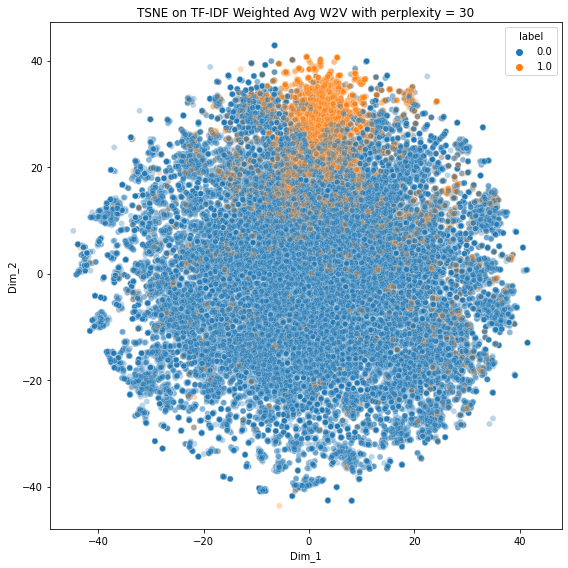

In [ ]:
fig,ax=plt.subplots(figsize=(8,8))
ax.set_title("TSNE on TF-IDF Weighted Avg W2V with perplexity = 30")
sns.scatterplot(x="Dim_1", y="Dim_2",hue="label",
data=tsne_df,legend="full",alpha=0.3,ax=ax)
fig.tight_layout()
plt.show()

1) Above is the T-SNE for the TF-IDF weighted  Avg W2V data and the Toxic and Non Toxic comments grouped with some overlapping.

2) And also Non Toxic clusters having Toxic points at the random 



In [ ]:
#TSNE on TF-IDF weighted average W2v with perplexity 50
model_1 = TSNE(n_components=2, random_state=0, perplexity=50,n_jobs=-1)
tsne_data_1 = model_1.fit_transform(X_train_tfidf_w2v)

# creating a new data fram which help us in ploting the result data
tsne_data_1 = np.vstack((tsne_data_1.T, y_train_tsne)).T
tsne_df_1 = pd.DataFrame(data=tsne_data_1, columns=("Dim_1", "Dim_2", "label"))

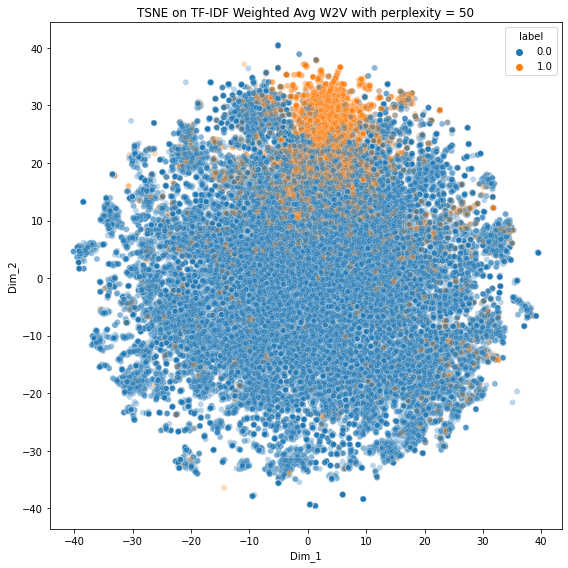

In [ ]:
fig,ax=plt.subplots(figsize=(8,8))
ax.set_title("TSNE on TF-IDF Weighted Avg W2V with perplexity = 50")
sns.scatterplot(x="Dim_1", y="Dim_2",hue="label",
data=tsne_df_1,legend="full",alpha=0.3,ax=ax)
fig.tight_layout()
plt.show()

1) Above is the T-SNE for the bi-gram data and the Toxic and Non Toxic comments grouped with some overlapping.

2) And also Non Toxic clusters having Toxic points at the random 

3) Different Perpelexity values gave more or less the similar results

4) TSNE on TF-IDF weighted Avg W2V is better than Uni,Bi grams of TF IDF.

Since TF-IDF weighted Avg W2V is advantageous in terms of scemantic meanings, let us continue modelling with the same.